# Can you help reduce employee turnover?

## Background

### Objective
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

### Data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

### Questions 
1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?

# Load libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import StrMethodFormatter
sns.set_palette('tab10')
sns.set_theme()
%matplotlib inline

In [ ]:
import mpl_toolkits
from sklearn import metrics
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from statsmodels.tools.tools import add_constant
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
# Linear Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
#Support Vector Matchine
from sklearn import svm
#KNN mathod
from sklearn.neighbors import KNeighborsClassifier
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Graident Boosting
from sklearn.ensemble import GradientBoostingClassifier
#AdaBoosting
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
df = pd.read_csv('./data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [ ]:
df2 = df.copy()

# Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


In [ ]:
df.describe()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


# Question 1

Which department has the highest employee turnover? Which one has the lowest?

In [ ]:
dep_pct = df.groupby('department')['left'].value_counts(normalize=True).reset_index(name = 'percent')

In [ ]:
dep_pct_left = dep_pct[dep_pct['left']=='yes']

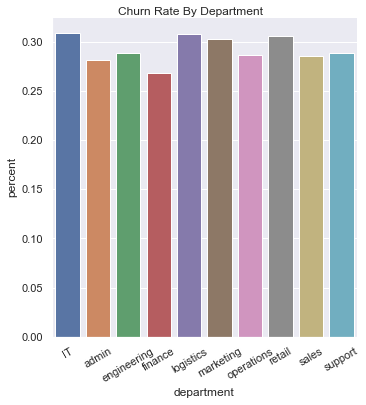

In [ ]:
g = sns.catplot(
    data=dep_pct_left, kind="bar",
    x="department", y="percent",
    ci="sd", height=5)
g.fig.suptitle("Churn Rate By Department",y=1)
g.set_xticklabels(rotation=30);

In [ ]:
dep_cnt = df.groupby('department')['left'].value_counts().reset_index(name = 'count')

In [ ]:
dep_cnt_left = dep_cnt[dep_cnt['left']=='yes']

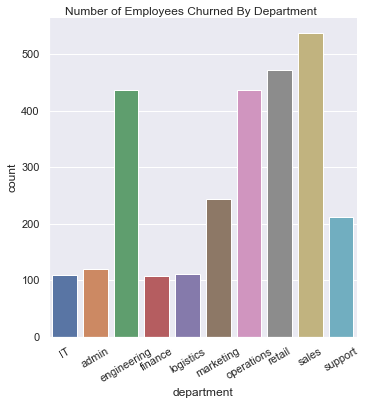

In [ ]:
g = sns.catplot(
    data=dep_cnt_left, kind="bar",
    x="department", y="count",
    ci="sd", height=5)
g.fig.suptitle("Number of Employees Churned By Department",y=1)
g.set_xticklabels(rotation=30);

In terms of percentage of churned employees, departments IT and logistics have the highest employee churn rate, even though the rates across all departments are at 30% or so. Oppositely, department finance has the lowest churn rate.

Looking at the absolute number of employees who left, department sales has the most people who churned, whereas department IT and finance have lowest number of churned employees.

# Question 2

Investigate which variables seem to be better predictors of employee departure.

## Feature engineering

In [ ]:
# Create dummy variables for categorical/discrete features
df = pd.get_dummies(df, columns=['department','salary','projects','tenure'])

In [ ]:
# Quantify target variable
df['target']=np.where(df['left']=='no',0,1)

### Normalisation

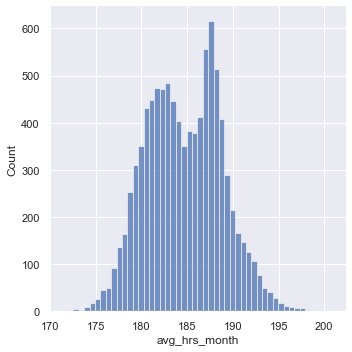

In [ ]:
sns.displot(df, x="avg_hrs_month")

In [ ]:
# Normalisation

x = pd.DataFrame(df.avg_hrs_month)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['avg_hrs_month_scaled'] = x_scaled

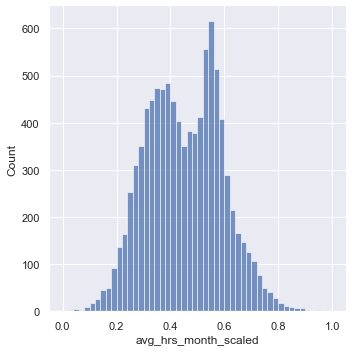

In [ ]:
sns.displot(df, x="avg_hrs_month_scaled")

In [ ]:
# Standardisation

df[['avg_hrs_month_stnd']] = StandardScaler().fit_transform(df[['avg_hrs_month']])

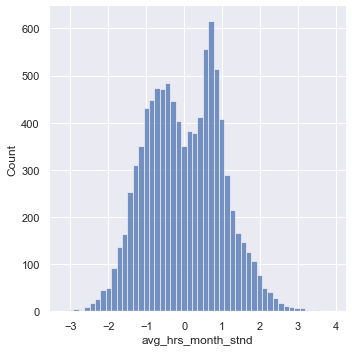

In [ ]:
sns.displot(df, x="avg_hrs_month_stnd")

In [ ]:
df.columns

Index(['promoted', 'review', 'satisfaction', 'bonus', 'avg_hrs_month', 'left',
       'department_IT', 'department_admin', 'department_engineering',
       'department_finance', 'department_logistics', 'department_marketing',
       'department_operations', 'department_retail', 'department_sales',
       'department_support', 'salary_high', 'salary_low', 'salary_medium',
       'projects_2', 'projects_3', 'projects_4', 'projects_5', 'tenure_2.0',
       'tenure_3.0', 'tenure_4.0', 'tenure_5.0', 'tenure_6.0', 'tenure_7.0',
       'tenure_8.0', 'tenure_9.0', 'tenure_10.0', 'tenure_11.0', 'tenure_12.0',
       'target', 'avg_hrs_month_scaled', 'avg_hrs_month_stnd'],
      dtype='object')

In [ ]:
df.drop(['left','department_support','salary_medium',
        'avg_hrs_month','avg_hrs_month_scaled',
         'projects_5', 'tenure_2.0'], axis=1, inplace=True)

In [ ]:
df.columns

Index(['promoted', 'review', 'satisfaction', 'bonus', 'department_IT',
       'department_admin', 'department_engineering', 'department_finance',
       'department_logistics', 'department_marketing', 'department_operations',
       'department_retail', 'department_sales', 'salary_high', 'salary_low',
       'projects_2', 'projects_3', 'projects_4', 'tenure_3.0', 'tenure_4.0',
       'tenure_5.0', 'tenure_6.0', 'tenure_7.0', 'tenure_8.0', 'tenure_9.0',
       'tenure_10.0', 'tenure_11.0', 'tenure_12.0', 'target',
       'avg_hrs_month_stnd'],
      dtype='object')

In [ ]:
c = df.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
corr_df = pd.DataFrame(so).reset_index()
corr_df.rename({'level_0':'var1','level_1':'var2',0:'corr_value'}, 
               axis=1, inplace=True)
corr_df[(corr_df["var1"]!=corr_df["var2"])]

,var1,var2,corr_value
30,projects_3,projects_4,0.861587
31,projects_4,projects_3,0.861587
32,avg_hrs_month_stnd,tenure_5.0,0.526300
33,tenure_5.0,avg_hrs_month_stnd,0.526300
34,avg_hrs_month_stnd,tenure_8.0,0.479236
...,...,...,...
895,projects_4,department_operations,0.000080
896,department_operations,satisfaction,0.000067
897,satisfaction,department_operations,0.000067
898,tenure_4.0,salary_high,0.000066


In [ ]:
df.drop(['projects_3'], axis=1, inplace=True)

<AxesSubplot:>

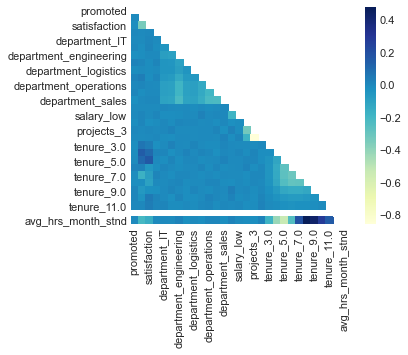

In [ ]:
plt.style.use('seaborn-white')
# Calculate correlation between each pair of variable
corr_matrix=df.corr()
 
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, square=True, cmap="YlGnBu")

In [ ]:
df.drop(['tenure_7.0'], axis=1, inplace=True)

In [ ]:
X = df.drop(['target'],axis=1) 
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
X = add_constant(X_train.iloc[:,1:])
vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
              index=X.columns)
pd.DataFrame(vif)[0].sort_values(ascending=False)

const                     126.443582
avg_hrs_month_stnd         22.840415
tenure_5.0                  8.796332
tenure_4.0                  6.285345
tenure_6.0                  4.014379
tenure_9.0                  3.545061
tenure_8.0                  2.871767
department_sales            2.831590
department_retail           2.584583
department_operations       2.575762
department_engineering      2.541620
tenure_10.0                 2.344915
tenure_3.0                  1.942355
department_marketing        1.894811
department_admin            1.507877
department_finance          1.491547
tenure_11.0                 1.473257
department_logistics        1.430868
department_IT               1.426855
review                      1.284637
satisfaction                1.267232
salary_high                 1.038667
salary_low                  1.036517
projects_2                  1.034862
projects_4                  1.034585
bonus                       1.002734
tenure_12.0                      NaN
N

In [ ]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

## Model Building

In [ ]:
df.target.value_counts()

0    6756
1    2784
Name: target, dtype: int64

In [ ]:
!pip install imbalanced-learn

     |████████████████████████████████| 199 kB 33.0 MB/s            
     |████████████████████████████████| 26.7 MB 107.5 MB/s            
     |████████████████████████████████| 306 kB 93.4 MB/s            
     |████████████████████████████████| 41.6 MB 90.9 MB/s            
     |████████████████████████████████| 16.8 MB 52.6 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.22.2 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.3 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.0.1 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Due to the imbalance of the dataset, SMOTE is applied to oversample minority class.

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=10)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

0    5426
1    5426
Name: target, dtype: int64

### Gradient Boosting Classifier

In [ ]:
k=0
ModelSummary = {}

In [ ]:
predictors = [x for x in df.columns if x not in ['target']]


Gradient Boosting Classifier Report
Accuracy: 0.8129
AUC Score: 0.896885


Text(0, 0.5, 'Feature Importance Score')

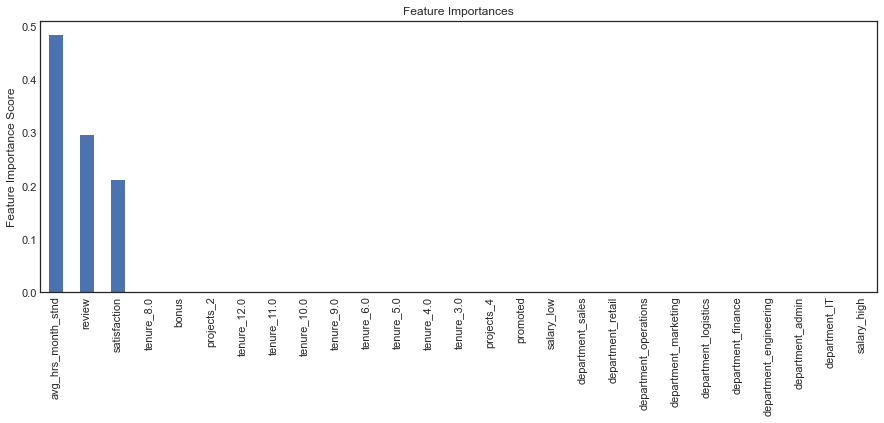

In [ ]:
model_gbc = GradientBoostingClassifier(n_estimators = 10, random_state=10)
model_gbc.fit(X_train,y_train)

y_pred_gbc = model_gbc.predict(X_test)
y_pred_gbc_prob = model_gbc.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nGradient Boosting Classifier Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_gbc))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_gbc_prob))

feat_imp = pd.Series(model_gbc.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Model Tuning

n_estimators

In [ ]:
param_test1 = {'n_estimators':range(50,301,50)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10), 
                                                            param_grid = param_test1, 
                                                            scoring='roc_auc',n_jobs=6,cv=5)
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 300} 0.9457566289484273


max_depth & min_samples_split

In [ ]:
param_test2 = {'max_depth':range(10,16,2), 'min_samples_split':range(10,21,5)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               n_estimators=300, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=10), 
                                                            param_grid = param_test2, 
                                                            scoring='roc_auc',n_jobs=1,cv=5)
gsearch2.fit(X_train, y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 14, 'min_samples_split': 10} 0.958603719214041


min_samples_leaf

In [ ]:
param_test3 = {'min_samples_leaf':range(10,31,5)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               n_estimators=300,
                                                               max_depth=14,
                                                               min_samples_split=10,
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=10), 
                                                            param_grid = param_test3, 
                                                            scoring='roc_auc',n_jobs=1,cv=5)
gsearch3.fit(X_train, y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

{'min_samples_leaf': 10} 0.9547202596298291


max_features

In [ ]:
param_test4 = {'max_features':range(5,12,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               n_estimators=300,
                                                               max_depth=14,
                                                               min_samples_split=10,
                                                               min_samples_leaf=10,
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=10), 
                                                            param_grid = param_test4, 
                                                            scoring='roc_auc',n_jobs=1,cv=5)
gsearch4.fit(X_train, y_train)
print(gsearch4.best_params_, gsearch4.best_score_)

{'max_features': 5} 0.9547202596298291


subsample

In [ ]:
param_test5 = {'subsample':[0.5,0.55,0.6,0.65]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               n_estimators=300,
                                                               max_depth=14,
                                                               min_samples_split=10,
                                                               min_samples_leaf=10,
                                                               max_features=5, 
                                                               subsample=0.8, 
                                                               random_state=10), 
                                                            param_grid = param_test5, 
                                                            scoring='roc_auc',n_jobs=1,cv=5)
gsearch5.fit(X_train, y_train)
print(gsearch5.best_params_, gsearch4.best_score_)

{'subsample': 0.65} 0.9547202596298291



Tuned Gradient Boosting Classifier Report
Accuracy: 0.8307
AUC Score: 0.908481


Text(0, 0.5, 'Feature Importance Score')

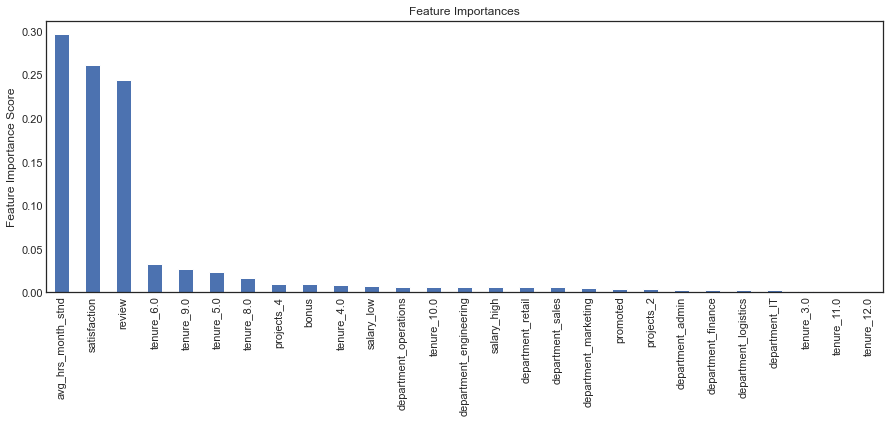

In [ ]:
model_gbc_tuned = GradientBoostingClassifier(learning_rate=0.15, 
                                            n_estimators=300,
                                            max_depth=14,
                                            min_samples_split=10,
                                            min_samples_leaf=10,
                                            max_features=5, 
                                            subsample=0.65, 
                                            random_state=42)
model_gbc_tuned.fit(X_train,y_train)

y_pred_gbc_tuned = model_gbc_tuned.predict(X_test)
y_pred_gbc_prob_tuned = model_gbc_tuned.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nTuned Gradient Boosting Classifier Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_gbc_tuned))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_gbc_prob_tuned))

feat_imp = pd.Series(model_gbc_tuned.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

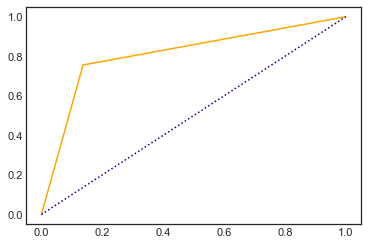

In [ ]:
#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_gbc_tuned)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

[[1148  141]
 [ 182  437]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1289
           1       0.76      0.71      0.73       619

    accuracy                           0.83      1908
   macro avg       0.81      0.80      0.80      1908
weighted avg       0.83      0.83      0.83      1908



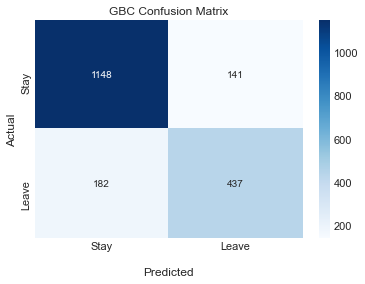

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}}


In [ ]:
print(confusion_matrix(y_pred_gbc_tuned,y_test))
print(classification_report(y_pred_gbc_tuned,y_test))

ax = sns.heatmap(confusion_matrix(y_pred_gbc_tuned,y_test), 
                 annot=True, fmt='g', cmap='Blues')

ax.set_title('GBC Confusion Matrix');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(['Stay','Leave'])
ax.yaxis.set_ticklabels(['Stay','Leave'])
plt.show()

#ProjectSummary
ModelName = 'GradientBoosting_classification'
Acc = accuracy_score(y_pred_gbc_tuned,y_test)
pres = precision_score(y_pred_gbc_tuned,y_test)
recal = recall_score(y_pred_gbc_tuned,y_test)
f1score = f1_score(y_pred_gbc_tuned,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)


### Logistic Regression

In [ ]:
logreg = LogisticRegression().fit(X_train, y_train)
logreg.fit(X_train,y_train)
y_pred_logreg=logreg.predict(X_test)

penalty = ['l1', 'l2']
C = [0.1,1]
hyperparameters = dict(C=C, penalty=penalty)
grid_logreg = GridSearchCV(logreg, hyperparameters, cv=3, verbose=0)

grid_logreg.fit(X_train, y_train)
y_pred_logreg = grid_logreg.predict(X_test)

In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",logreg.coef_.transpose())

In [ ]:
coef_table.rename({0:'Feature'},axis=1,inplace=True)
coef_table = coef_table.sort_values(by=['Coefs'], ascending=False)
coef_table.head(1)

,Feature,Coefs
1,review,13.571322


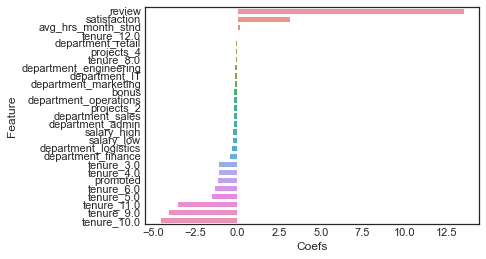

In [ ]:
sns.barplot(y="Feature", x="Coefs", data=coef_table);

[[940 145]
 [390 433]]
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      1085
           1       0.75      0.53      0.62       823

    accuracy                           0.72      1908
   macro avg       0.73      0.70      0.70      1908
weighted avg       0.73      0.72      0.71      1908



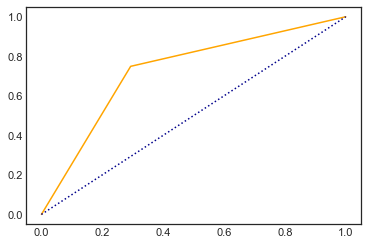

In [ ]:
print(confusion_matrix(y_pred_logreg,y_test))
print(classification_report(y_pred_logreg,y_test))

#ProjectSummary
ModelName = 'Logistic_Regression_classification'
Acc = accuracy_score(y_pred_logreg,y_test)
pres = precision_score(y_pred_logreg,y_test)
recal = recall_score(y_pred_logreg,y_test)
f1score = f1_score(y_pred_logreg,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1

#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_logreg)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

### KNN Classification

Find optimal K

In [ ]:
accuracy_CV=[]
for i in range(2,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    accuracy_CV.append(scores_knn.mean()) 

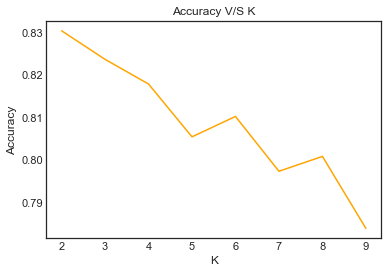

In [ ]:
plt.plot(list(range(2,10)),accuracy_CV,color="orange",label="Accuracy")
plt.title("Accuracy V/S K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

KNeighborsClassifier Model Accuracy :  0.7783018867924528
[[1181  274]
 [ 149  304]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1455
           1       0.53      0.67      0.59       453

    accuracy                           0.78      1908
   macro avg       0.71      0.74      0.72      1908
weighted avg       0.80      0.78      0.79      1908

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}, 1: {'ModelName': 'Logistic_Regression_classification', 'ModeAccuracy': 0.7196016771488469, 'Precision': 0.7491349480968859, 'Recall': 0.5261239368165249, 'f1score': 0.6181299072091363}, 2: {'ModelName': 'KNeighbors_classification', 'ModeAccuracy': 0.7783018867924528, 'Precision': 0.5259515570934256, 'Recall': 0.6710816777041942, 'f1score': 0.5897187196896216}}


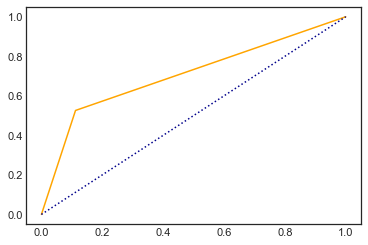

In [ ]:
knn_tuned = KNeighborsClassifier(n_neighbors=2)
knn_tuned.fit(X_train,y_train)
y_pred_knn = knn_tuned.predict(X_test)

print('KNeighborsClassifier Model Accuracy : ', accuracy_score(y_pred_knn,y_test))
print(confusion_matrix(y_pred_knn,y_test))
print(classification_report(y_pred_knn,y_test))

#ProjectSummary
ModelName = 'KNeighbors_classification'
Acc = accuracy_score(y_pred_knn,y_test)
pres = precision_score(y_pred_knn,y_test)
recal = recall_score(y_pred_knn,y_test)
f1score = f1_score(y_pred_knn,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)

#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_knn)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

## Random Forest

In [ ]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)

In [ ]:
params ={
    'criterion':['gini','entropy'],
    'n_estimators':[int(x) for x in np.linspace(start=100 ,stop=1000,num=10)],
    'max_depth':[int(x) for x in np.linspace(10,1000,10)],
    'max_features':['auto','sqrt','log2'],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4,6,8]
}

In [ ]:
rf=RandomizedSearchCV(estimator=rf,param_distributions=params,
                      n_iter=5,scoring='accuracy',cv=5,verbose=2,
                      n_jobs=-1,random_state=10)

rf.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=10, scoring='accuracy', verbose=2)

In [ ]:
rf.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 230,
 'criterion': 'gini'}

In [ ]:
best_random =rf.best_estimator_
best_random

RandomForestClassifier(max_depth=230, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000)

In [ ]:
rf_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=230, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf_tuned.fit(X_train,y_train)
y_pred_rf = rf_tuned.predict(X_test)
print('RandomForestClassifier Model Accuracy : ', accuracy_score(y_pred_rf,y_test))
confusion_matrix(y_pred_rf,y_test)

RandomForestClassifier Model Accuracy :  0.8359538784067087


array([[1140,  123],
       [ 190,  455]])

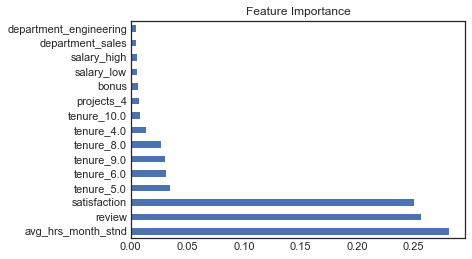

In [ ]:
feat_importances = pd.Series(rf_tuned.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}, 1: {'ModelName': 'Logistic_Regression_classification', 'ModeAccuracy': 0.7196016771488469, 'Precision': 0.7491349480968859, 'Recall': 0.5261239368165249, 'f1score': 0.6181299072091363}, 2: {'ModelName': 'KNeighbors_classification', 'ModeAccuracy': 0.7783018867924528, 'Precision': 0.5259515570934256, 'Recall': 0.6710816777041942, 'f1score': 0.5897187196896216}, 3: {'ModelName': 'RandomForest_classification', 'ModeAccuracy': 0.8359538784067087, 'Precision': 0.78719723183391, 'Recall': 0.7054263565891473, 'f1score': 0.7440719542109566}}


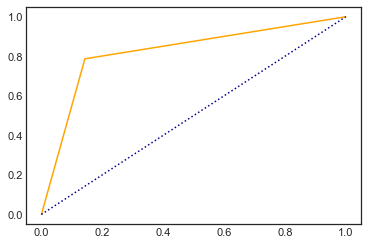

In [ ]:
#ProjectSummary
ModelName = 'RandomForest_classification'
Acc = accuracy_score(y_pred_rf,y_test)
pres = precision_score(y_pred_rf,y_test)
recal = recall_score(y_pred_rf,y_test)
f1score = f1_score(y_pred_rf,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)

#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_rf)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

### Adaboost

In [ ]:
ada = AdaBoostClassifier(random_state=42)
ada_grid = {'n_estimators': range(50,150,10),
            'algorithm': ['SAMME','SAMME.R'],
            'learning_rate': [0.001,0.1,0.2,0.5]
              }

In [ ]:
ada=GridSearchCV(estimator=ada
                ,param_grid=ada_grid
                ,n_jobs=-1
                ,scoring='accuracy'
                ,cv=5
                )

In [ ]:
ada.fit(X_train,y_train)
ada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 90}

In [ ]:
ada_tuned = AdaBoostClassifier(algorithm='SAMME.R',
                               learning_rate=0.5,
                               n_estimators=90)
ada_tuned.fit(X_train,y_train)
y_pred_ada = ada_tuned.predict(X_test)
print('AdaBoostClassifier Model Accuracy : ', accuracy_score(y_pred_ada,y_test)*100,'%')
confusion_matrix(y_pred_ada,y_test)

AdaBoostClassifier Model Accuracy :  78.72117400419287 %


array([[1047,  123],
       [ 283,  455]])

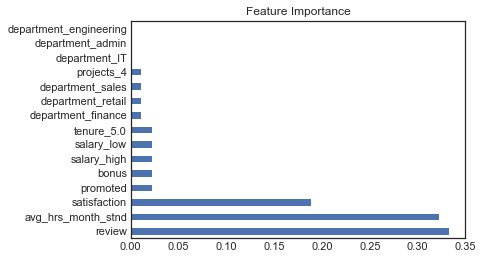

In [ ]:
feat_importances = pd.Series(ada_tuned.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}, 1: {'ModelName': 'Logistic_Regression_classification', 'ModeAccuracy': 0.7196016771488469, 'Precision': 0.7491349480968859, 'Recall': 0.5261239368165249, 'f1score': 0.6181299072091363}, 2: {'ModelName': 'KNeighbors_classification', 'ModeAccuracy': 0.7783018867924528, 'Precision': 0.5259515570934256, 'Recall': 0.6710816777041942, 'f1score': 0.5897187196896216}, 3: {'ModelName': 'RandomForest_classification', 'ModeAccuracy': 0.8359538784067087, 'Precision': 0.78719723183391, 'Recall': 0.7054263565891473, 'f1score': 0.7440719542109566}, 4: {'ModelName': 'AdaBoosting_classification', 'ModeAccuracy': 0.7872117400419287, 'Precision': 0.78719723183391, 'Recall': 0.6165311653116531, 'f1score': 0.6914893617021276}}


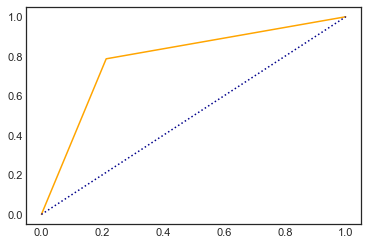

In [ ]:
#ProjectSummary
ModelName = 'AdaBoosting_classification'
Acc = accuracy_score(y_pred_ada,y_test)
pres = precision_score(y_pred_ada,y_test)
recal = recall_score(y_pred_ada,y_test)
f1score = f1_score(y_pred_ada,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)

#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_ada)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

### XGBoost

In [ ]:
xgb = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1
                    )
xgb.fit(X_train, y_train)

[10:17:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)


XGB Model Report
Accuracy: 0.8307
AUC Score: 0.918963


Text(0, 0.5, 'Feature Importance Score')

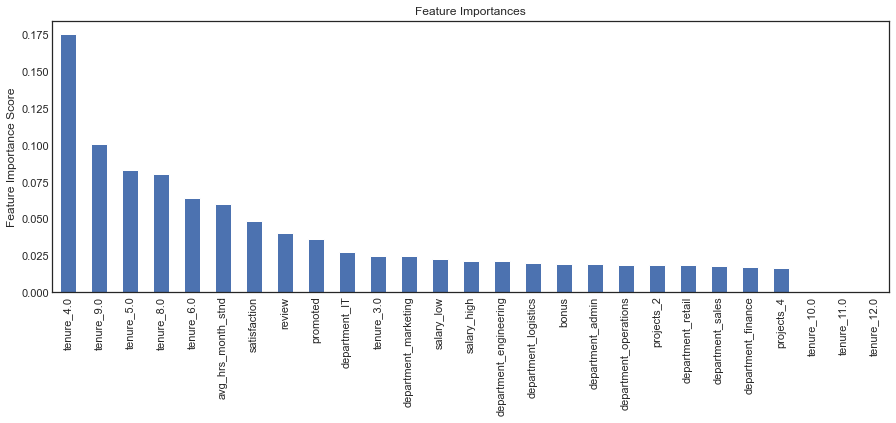

In [ ]:
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nXGB Model Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_xgb))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_prob_xgb))

feat_imp = pd.Series(xgb.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Model Tuning

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140,
                                                  max_depth=5,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=27,
                                                 eval_metric='rmse'), 
                        param_grid = param_test1, scoring='roc_auc',
                        n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

{'max_depth': 9, 'min_child_weight': 1} 0.9489568987091449
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END criterion=entropy, max_depth=670, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END criterion=entropy, max_depth=670, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=500; total time=   0.0s
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_est

In [ ]:
param_test2 = {
 'max_depth':range(9,14,1),
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140,
                                                  max_depth=9,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=27,
                                                 eval_metric='rmse'), 
                        param_grid = param_test2, scoring='roc_auc',
                        n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'gamma': 0.1, 'max_depth': 11} 0.9505312198479061


In [ ]:
xgb_tuned = XGBClassifier(learning_rate =0.1,
                             n_estimators=1000,
                             max_depth=11,
                             min_child_weight=1,
                             gamma=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)


XGB Tuned Model Report
Accuracy: 0.8312
AUC Score: 0.911720


Text(0, 0.5, 'Feature Importance Score')

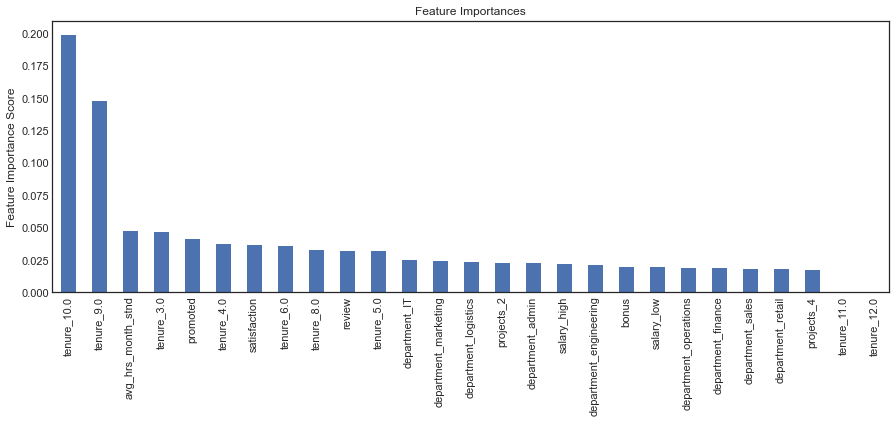

In [ ]:
xgb_tuned.fit(X_train, y_train,eval_metric='rmse')
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
y_pred_prob_xgb_tuned = xgb_tuned.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nXGB Tuned Model Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_xgb_tuned))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_prob_xgb_tuned))

feat_imp = pd.Series(xgb_tuned.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

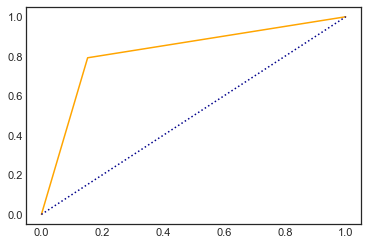

In [ ]:
#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_xgb_tuned)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

In [ ]:
print(confusion_matrix(y_pred_xgb_tuned,y_test))
print(classification_report(y_pred_xgb_tuned,y_test))

#ProjectSummary
ModelName = 'XGBoosting_classification'
Acc = accuracy_score(y_pred_xgb_tuned,y_test)
pres = precision_score(y_pred_xgb_tuned,y_test)
recal = recall_score(y_pred_xgb_tuned,y_test)
f1score = f1_score(y_pred_xgb_tuned,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)

[[1128  120]
 [ 202  458]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1248
           1       0.79      0.69      0.74       660

    accuracy                           0.83      1908
   macro avg       0.82      0.80      0.81      1908
weighted avg       0.83      0.83      0.83      1908

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}, 1: {'ModelName': 'Logistic_Regression_classification', 'ModeAccuracy': 0.7196016771488469, 'Precision': 0.7491349480968859, 'Recall': 0.5261239368165249, 'f1score': 0.6181299072091363}, 2: {'ModelName': 'KNeighbors_classification', 'ModeAccuracy': 0.7783018867924528, 'Precision': 0.5259515570934256, 'Recall': 0.6710816777041942, 'f1score': 0.5897187196896216}, 3: {'ModelName': 'RandomForest_classification', 'ModeAccuracy': 0.8359538784067087, 'Precision': 0.

In [ ]:
ModelName,ModeAccuracy,Precision,Recall,f1score = [],[],[],[],[]
import json
sorted_json_data = json.dumps(ModelSummary, sort_keys=True)
finalJson = json.loads(sorted_json_data)
finalJson
for i in range(len(finalJson)):
    List = finalJson[str(i)]
    ModelName.append(List['ModelName'])
    ModeAccuracy.append(List['ModeAccuracy'])
    Precision.append(List['Precision'])
    Recall.append(List['Recall'])
    f1score.append(List['f1score'])
df = pd.DataFrame()
df['ModelName'] = ModelName
df['ModeAccuracy'] = ModeAccuracy
df['Precision'] = Precision
df['Recall'] = Recall
df['f1score'] = f1score

df

,ModelName,ModeAccuracy,Precision,Recall,f1score
0,GradientBoosting_classification,0.830713,0.756055,0.705977,0.730159
1,Logistic_Regression_classification,0.719602,0.749135,0.526124,0.618130
2,KNeighbors_classification,0.778302,0.525952,0.671082,0.589719
3,RandomForest_classification,0.835954,0.787197,0.705426,0.744072
4,AdaBoosting_classification,0.787212,0.787197,0.616531,0.691489
5,XGBoosting_classification,0.831237,0.792388,0.693939,0.739903


In [ ]:
# Model with highest accuracy
df.sort_values('ModeAccuracy',ascending=False).head(1)

,ModelName,ModeAccuracy,Precision,Recall,f1score
3,RandomForest_classification,0.835954,0.787197,0.705426,0.744072


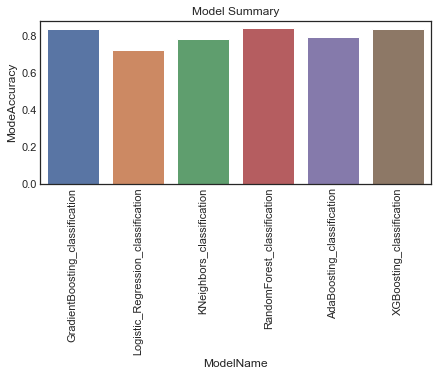

In [ ]:
plt.figure(figsize=(7,3))
sns.barplot(df['ModelName'],df['ModeAccuracy'])
plt.title('Model Summary')
plt.xticks(rotation=90)
plt.show()

For models with higher accuracies like Gradient Boosting Classifier, Random Forest and XGBoost Classifier, there are common features which are regarded as significant: average hours per month, review, satisfaction. 


#### Average Hours Per Month

In [ ]:
# Sample same number of data points from both classes
df_bal = df2.groupby('left').apply(lambda s: s.sample(800)).reset_index(drop=True)

In [ ]:
df_bal.left.value_counts()

no     800
yes    800
Name: left, dtype: int64

In [ ]:
left_avg = pd.DataFrame(df_bal[df_bal["left"]=="yes"]['avg_hrs_month']).reset_index()
stay_avg = pd.DataFrame(df_bal[df_bal["left"]=="no"]['avg_hrs_month']).reset_index()

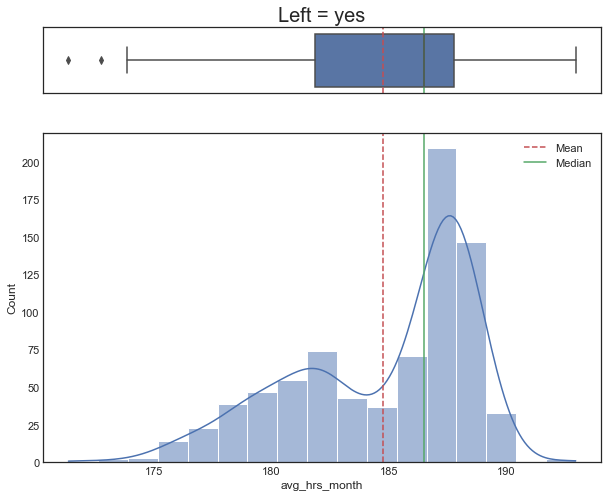

In [ ]:
rcParams['figure.figsize'] = 10,8
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=left_avg['avg_hrs_month'].mean()
median=left_avg['avg_hrs_month'].median()

sns.boxplot(data=left_avg, x="avg_hrs_month", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.histplot(data=left_avg, x="avg_hrs_month", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")

ax_hist.legend()

ax_box.set(xlabel='')
ax_box.set_title('Left = yes', fontsize=20)
plt.show()

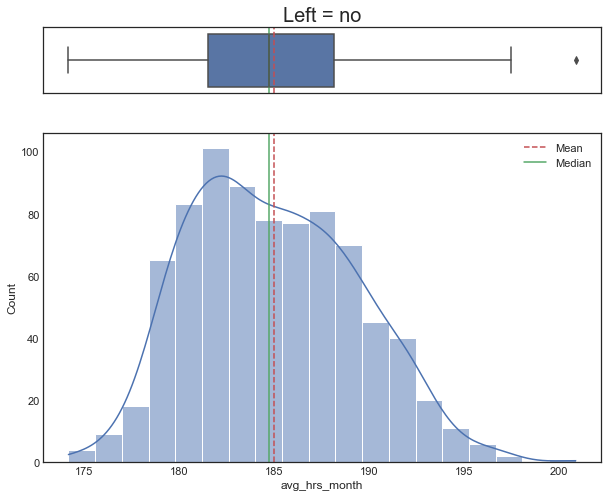

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=stay_avg['avg_hrs_month'].mean()
median=stay_avg['avg_hrs_month'].median()

sns.boxplot(data=stay_avg, x="avg_hrs_month", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.histplot(data=stay_avg, x="avg_hrs_month", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")

ax_hist.legend()

ax_box.set(xlabel='')
ax_box.set_title('Left = no', fontsize=20)
plt.show()

By examining the charts above, the average working hours per month for two groups are similar -- 185 hours (approximately 9.25h/workday). Both groups have two peaks around 183 hrs and 187 hrs. However, the median for churned group is higher and has a left skewed distribution which means more people tend to work longer.

#### Review

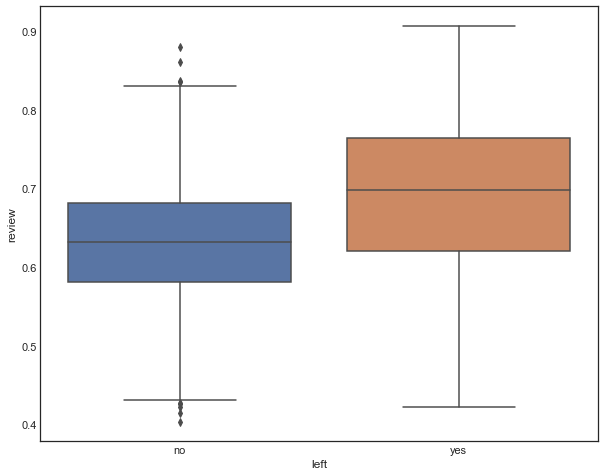

In [ ]:
sns.boxplot(x="left", y="review",
            data=df_bal);

Based on the box plot, churned employees have higher average review ratings and the variance is also larger. Employees who didn't leave tend to have lower review ratings.

#### Satisfaction

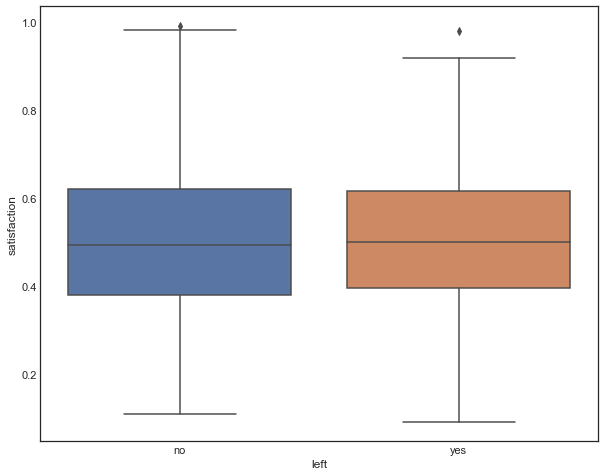

In [ ]:
sns.boxplot(x="left", y="satisfaction",
            data=df_bal);

Average satisfaction scores do not vary much from one group to the other. The ranges are similar too.

There are some other features which are considered important in other models including tenure and promoted. 

# Question 3

What recommendations would you make regarding ways to reduce employee turnover?

## Split projects and share the burden

Based on previous analysis, IT department is one of the departments with the highest employee churn rate and the average working hours per month is identified as a strong predictor for employee churn. From the boxplot below, it is obvious that people working at IT department have relatively high average working hours per month. 

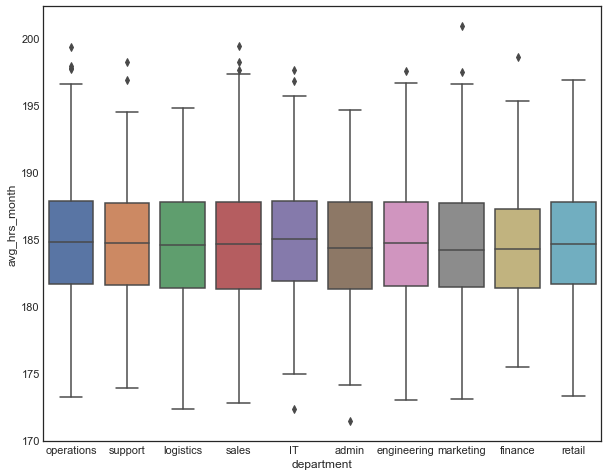

In [ ]:
rcParams['figure.figsize'] = 10,8
sns.boxplot(x="department", y="avg_hrs_month",
            data=df2);

One possible reason might be that IT people who lack the skills need to work longer hours to complete the target or project. For example, junior employees may take longer hours to code and deliver projects. However, from the plot of average work hours in IT department across all tenure groups, senior employees tend to have higher working hours. This leads to another possible reason that the senior employees have more projects to do.

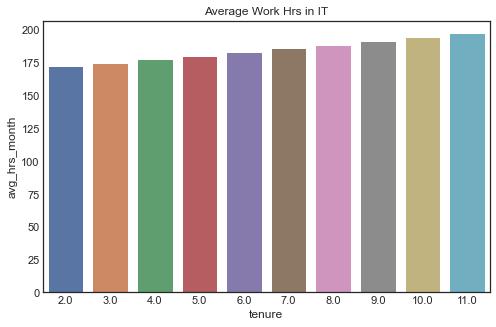

In [ ]:
rcParams['figure.figsize'] = 8,5
it_tenure_hrs = df2[df2['department']=='IT'].groupby('tenure')['avg_hrs_month'].mean().reset_index()

sns.barplot(x="tenure", y="avg_hrs_month",
            data=it_tenure_hrs).set_title('Average Work Hrs in IT');

Therefore, the next step is to see if there's a huge difference in the number of projects conducted between junior and senior people. 

From the graph below, apparently employees with 3 years of tenure tend to have the most projects to do. Also from the satisfaction plot, this group of people has the lowest satisfaction. Therefore, it is recommended to break the projects down and share some with employees with 2 years of experience to share the burden. This may help employees with too much work to maintain a more balanced work-life. 

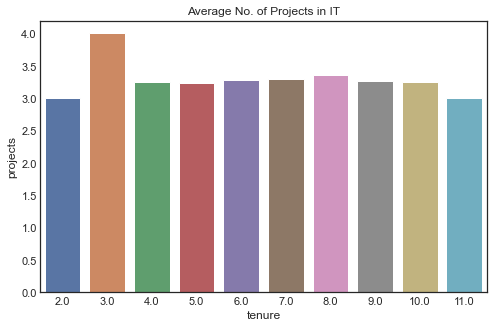

In [ ]:
it_tenure_prj = df2[df2['department']=='IT'].groupby('tenure')['projects'].mean().reset_index()

sns.barplot(x="tenure", y="projects",
            data=it_tenure_prj).set_title('Average No. of Projects in IT');

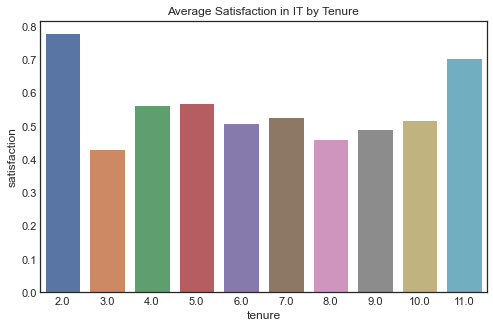

In [ ]:
it_tenure_sat = df2[df2['department']=='IT'].groupby('tenure')['satisfaction'].mean().reset_index()
sns.barplot(x="tenure", y="satisfaction",
            data=it_tenure_sat).set_title('Average Satisfaction in IT by Tenure');

## Establish fair and transparent promotion paths to get more mid-senior level employees promoted

In the group without promotion (promoted = 0), more people left.

From the boxplot below, there are employees with very high reviews weren't promoted in last 2 years. In addition, the average ratings for people who got promoted and those who didn't are very close. This implies that the promotion is not decided by reviews only, or the review itself is not a strong indicator for promotion. 

Articulating what employees need to achieve in order to get promoted might ensure each employee has a clear vision of what they lack and need to focus. 

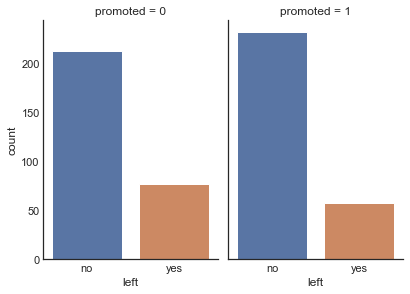

In [ ]:
p_cat = df2.groupby('promoted')
p_cat = pd.DataFrame(p_cat.apply(lambda x: x.sample(p_cat.size().min()).reset_index(drop=True)))
g = sns.catplot(x="left", col="promoted",
                data=p_cat, kind="count", col_wrap=2,
               height=4, aspect=.7);

In [ ]:
p_cat.promoted.value_counts()

0    289
1    289
Name: promoted, dtype: int64

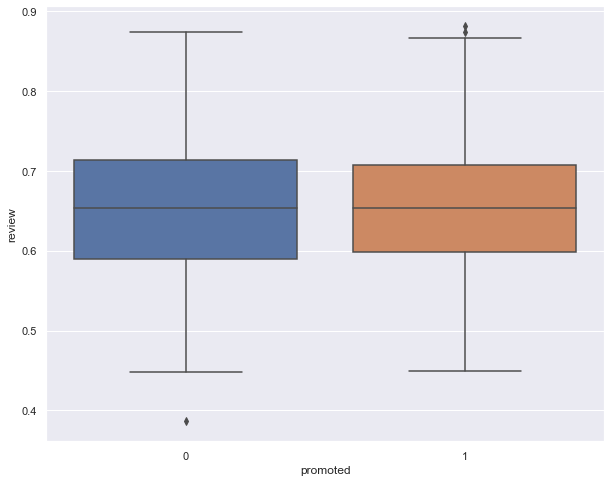

In [ ]:
rcParams['figure.figsize'] = 10,8
sns.boxplot(x="promoted", y="review",
            data=p_cat);

Another problem with promotion is that in the past 24 months, employees with long tenures were seldom promoted.

There might be a bias in below graph because people who got promoted in last 2 years now fall into a different tenure group. To capture the true satisfaction, an adjusted column is created so that any employees got promoted, the tenure is discounted.

In [ ]:
prom_cnt = df2.groupby(['tenure'])['promoted'].value_counts().reset_index(name = 'Count')
prom_cnt_y = prom_cnt[prom_cnt['promoted']==1]

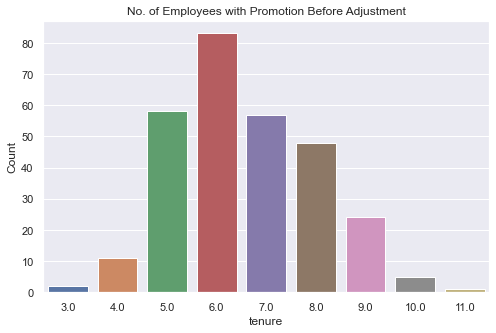

In [ ]:
rcParams['figure.figsize'] = 8,5
sns.barplot(x="tenure", 
            y="Count", 
            data=prom_cnt_y).set_title('No. of Employees with Promotion Before Adjustment');

In [ ]:
df2['tenure_adj'] = np.where(df2['promoted']==1, df2['tenure']-2, df2['tenure'])

In [ ]:
df2.promoted.value_counts()

0    9251
1     289
Name: promoted, dtype: int64

In [ ]:
df_bal_p = df2.groupby('promoted').apply(lambda s: s.sample(289)).reset_index(drop=True)
df_bal_p.promoted.value_counts()

0    289
1    289
Name: promoted, dtype: int64

In [ ]:
prom_cnt = df_bal_p.groupby(['tenure_adj'])['promoted'].value_counts().reset_index(name = 'Count')
prom_cnt_y = prom_cnt[prom_cnt['promoted']==1]

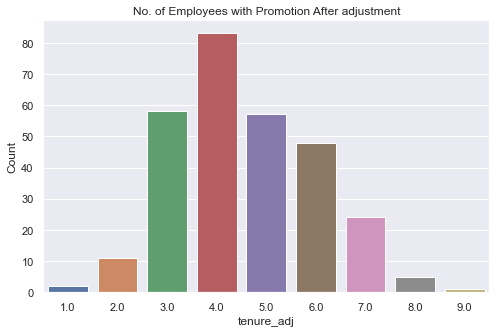

In [ ]:
sns.barplot(x="tenure_adj", 
            y="Count", 
            data=prom_cnt_y).set_title('No. of Employees with Promotion After adjustment');

No employees with 10 years or more tenures are shown above. This implies that senior level people may face hurdles in progressing their career.

Looking at the average satisfaction for employees with 8 to 10 years of tenure, they have lower satisfaction. 

In [ ]:
ten_pro_sat_adj = df_bal_p.groupby(['tenure_adj',
                              'left',
                              'promoted'])['satisfaction'].mean().reset_index(name = 'Avg. Satisfaction')
ten_pro_sat_prom_adj = ten_pro_sat_adj[ten_pro_sat_adj['promoted']==1]
ten_pro_sat_nonprom_adj = ten_pro_sat_adj[ten_pro_sat_adj['promoted']==0]

Text(0.5, 1.0, 'Not promoted')

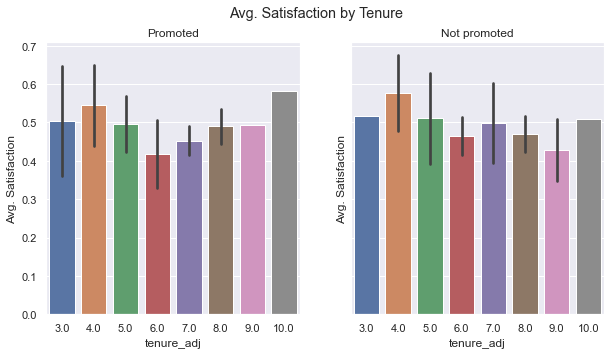

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle('Avg. Satisfaction by Tenure')

sns.barplot(ax=axes[0],
            x="tenure_adj", 
            y="Avg. Satisfaction", 
            data=ten_pro_sat_prom_adj).set_title('Promoted')
sns.barplot(ax=axes[1],
            x="tenure_adj", 
            y="Avg. Satisfaction", 
            data=ten_pro_sat_nonprom_adj).set_title('Not promoted')


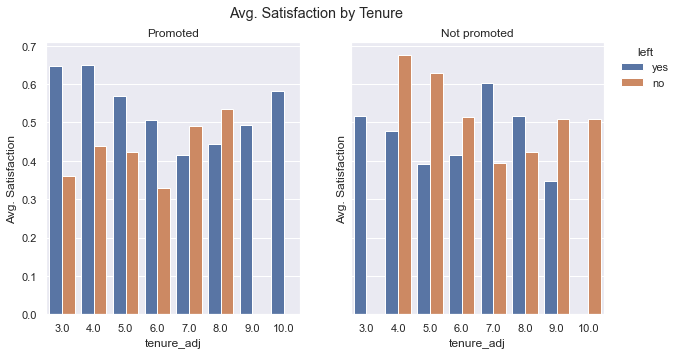

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle('Avg. Satisfaction by Tenure')

sns.barplot(ax=axes[0],
            x="tenure_adj", 
            y="Avg. Satisfaction", 
            hue="left", 
            data=ten_pro_sat_prom_adj).set_title('Promoted')
sns.barplot(ax=axes[1],
            x="tenure_adj", 
            y="Avg. Satisfaction", 
            hue="left", 
            data=ten_pro_sat_nonprom_adj).set_title('Not promoted')

axes[0].legend([],[], frameon=False)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, title='left',borderaxespad=0.);

## Implement comprehensive review metrics

This suggestion is linked to the previous one. For employees with high review ratings but didn't get promoted, the satisfaction of working in the company may decrease. This may explain why employees with high review ratings can have low satisfaction rate. 

Becuase not everyone who has a high rating can be promoted or rewarded, an accurate and comprehensive review to capture employees' performance and reflect the real situation and help employees identify areas for improvement. A spurious high review score will set the expectation too high, as employees may anticipate they will get promoted. A comprehensive metrics can motivate them to work and cultivate a positive working culture. Consequently, employees can receive a fair rating without to be disappointed.

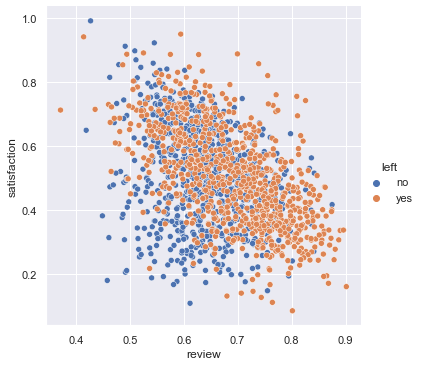

In [ ]:
sns.relplot(x="review", y="satisfaction", 
            hue="left", data=df_bal);

To further clarify, after plotting the linear relationship between average work hours and reviews, both features are not good at separating promoted and unpromoted employees. People with low average work hours and low review ratings can also be promoted, which sounds counter intuitive and might be one of the reasons for people to leave.

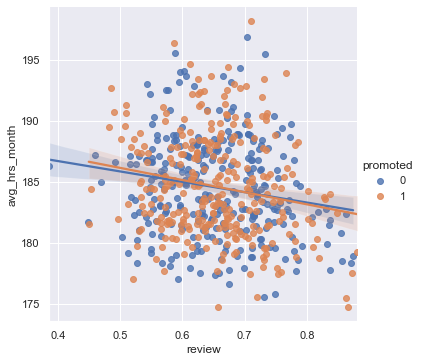

In [ ]:
g = sns.lmplot(
    data=p_cat,
    x="review", y="avg_hrs_month", hue="promoted",
    height=5
);

# Can you help reduce employee turnover?

## Background

### Objective
You work for the human capital department of a large corporation. The Board is worried about the relatively high turnover, and your team must look into ways to reduce the number of employees leaving the company.

The team needs to understand better the situation, which employees are more likely to leave, and why. Once it is clear what variables impact employee churn, you can present your findings along with your ideas on how to attack the problem.

### Data
The department has assembled data on almost 10,000 employees. The team used information from exit interviews, performance reviews, and employee records.

### Questions 
1. Which department has the highest employee turnover? Which one has the lowest?
2. Investigate which variables seem to be better predictors of employee departure.
3. What recommendations would you make regarding ways to reduce employee turnover?

# Load libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import StrMethodFormatter
sns.set_palette('tab10')
sns.set_theme()
%matplotlib inline

In [ ]:
import mpl_toolkits
from sklearn import metrics
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from statsmodels.tools.tools import add_constant
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier
# Linear Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
#Support Vector Matchine
from sklearn import svm
#KNN mathod
from sklearn.neighbors import KNeighborsClassifier
#Decision Tree
from sklearn.tree import DecisionTreeClassifier
#Random Forest
from sklearn.ensemble import RandomForestClassifier
#Graident Boosting
from sklearn.ensemble import GradientBoostingClassifier
#AdaBoosting
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
df = pd.read_csv('./data/employee_churn_data.csv')
df.head()

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no


In [ ]:
df2 = df.copy()

# Overview

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


In [ ]:
df.describe()

,promoted,review,projects,tenure,satisfaction,bonus,avg_hrs_month
count,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000,9540.000000
mean,0.030294,0.651826,3.274843,6.556184,0.504645,0.212055,184.661571
std,0.171403,0.085307,0.579136,1.415432,0.158555,0.408785,4.144831
min,0.000000,0.310000,2.000000,2.000000,0.000000,0.000000,171.374060
25%,0.000000,0.592884,3.000000,5.000000,0.386801,0.000000,181.472085
50%,0.000000,0.647456,3.000000,7.000000,0.500786,0.000000,184.628796
75%,0.000000,0.708379,4.000000,8.000000,0.622607,0.000000,187.728708
max,1.000000,1.000000,5.000000,12.000000,1.000000,1.000000,200.861656


# Question 1

Which department has the highest employee turnover? Which one has the lowest?

In [ ]:
dep_pct = df.groupby('department')['left'].value_counts(normalize=True).reset_index(name = 'percent')

In [ ]:
dep_pct_left = dep_pct[dep_pct['left']=='yes']

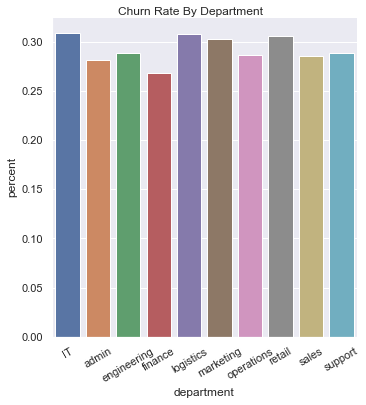

In [ ]:
g = sns.catplot(
    data=dep_pct_left, kind="bar",
    x="department", y="percent",
    ci="sd", height=5)
g.fig.suptitle("Churn Rate By Department",y=1)
g.set_xticklabels(rotation=30);

In [ ]:
dep_cnt = df.groupby('department')['left'].value_counts().reset_index(name = 'count')

In [ ]:
dep_cnt_left = dep_cnt[dep_cnt['left']=='yes']

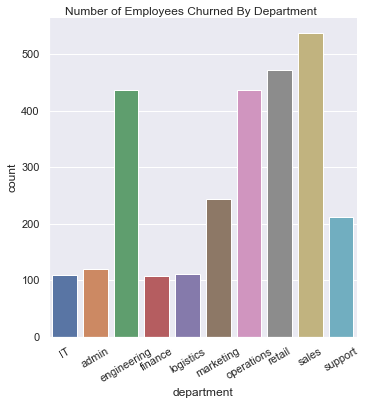

In [ ]:
g = sns.catplot(
    data=dep_cnt_left, kind="bar",
    x="department", y="count",
    ci="sd", height=5)
g.fig.suptitle("Number of Employees Churned By Department",y=1)
g.set_xticklabels(rotation=30);

In terms of percentage of churned employees, departments IT and logistics have the highest employee churn rate, even though the rates across all departments are at 30% or so. Oppositely, department finance has the lowest churn rate.

Looking at the absolute number of employees who left, department sales has the most people who churned, whereas department IT and finance have lowest number of churned employees.

# Question 2

Investigate which variables seem to be better predictors of employee departure.

## Feature engineering

In [ ]:
# Create dummy variables for categorical/discrete features
df = pd.get_dummies(df, columns=['department','salary','projects','tenure'])

In [ ]:
# Quantify target variable
df['target']=np.where(df['left']=='no',0,1)

### Normalisation

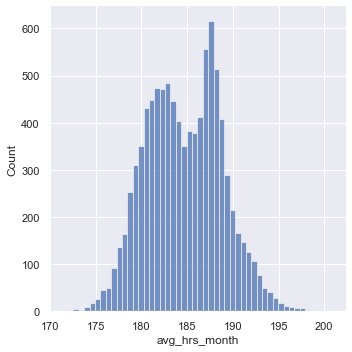

In [ ]:
sns.displot(df, x="avg_hrs_month")

In [ ]:
# Normalisation

x = pd.DataFrame(df.avg_hrs_month)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['avg_hrs_month_scaled'] = x_scaled

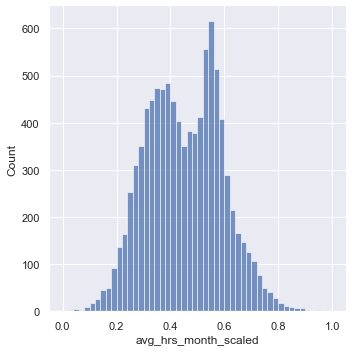

In [ ]:
sns.displot(df, x="avg_hrs_month_scaled")

In [ ]:
# Standardisation

df[['avg_hrs_month_stnd']] = StandardScaler().fit_transform(df[['avg_hrs_month']])

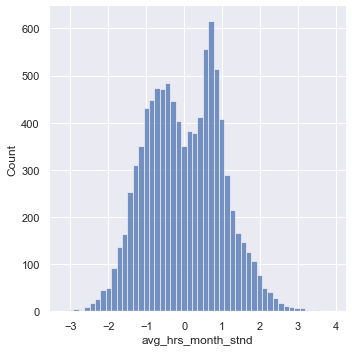

In [ ]:
sns.displot(df, x="avg_hrs_month_stnd")

In [ ]:
df.columns

Index(['promoted', 'review', 'satisfaction', 'bonus', 'avg_hrs_month', 'left',
       'department_IT', 'department_admin', 'department_engineering',
       'department_finance', 'department_logistics', 'department_marketing',
       'department_operations', 'department_retail', 'department_sales',
       'department_support', 'salary_high', 'salary_low', 'salary_medium',
       'projects_2', 'projects_3', 'projects_4', 'projects_5', 'tenure_2.0',
       'tenure_3.0', 'tenure_4.0', 'tenure_5.0', 'tenure_6.0', 'tenure_7.0',
       'tenure_8.0', 'tenure_9.0', 'tenure_10.0', 'tenure_11.0', 'tenure_12.0',
       'target', 'avg_hrs_month_scaled', 'avg_hrs_month_stnd'],
      dtype='object')

In [ ]:
df.drop(['left','department_support','salary_medium',
        'avg_hrs_month','avg_hrs_month_scaled',
         'projects_5', 'tenure_2.0'], axis=1, inplace=True)

In [ ]:
df.columns

Index(['promoted', 'review', 'satisfaction', 'bonus', 'department_IT',
       'department_admin', 'department_engineering', 'department_finance',
       'department_logistics', 'department_marketing', 'department_operations',
       'department_retail', 'department_sales', 'salary_high', 'salary_low',
       'projects_2', 'projects_3', 'projects_4', 'tenure_3.0', 'tenure_4.0',
       'tenure_5.0', 'tenure_6.0', 'tenure_7.0', 'tenure_8.0', 'tenure_9.0',
       'tenure_10.0', 'tenure_11.0', 'tenure_12.0', 'target',
       'avg_hrs_month_stnd'],
      dtype='object')

In [ ]:
c = df.corr().abs()

s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
corr_df = pd.DataFrame(so).reset_index()
corr_df.rename({'level_0':'var1','level_1':'var2',0:'corr_value'}, 
               axis=1, inplace=True)
corr_df[(corr_df["var1"]!=corr_df["var2"])]

,var1,var2,corr_value
30,projects_3,projects_4,0.861587
31,projects_4,projects_3,0.861587
32,avg_hrs_month_stnd,tenure_5.0,0.526300
33,tenure_5.0,avg_hrs_month_stnd,0.526300
34,avg_hrs_month_stnd,tenure_8.0,0.479236
...,...,...,...
895,projects_4,department_operations,0.000080
896,department_operations,satisfaction,0.000067
897,satisfaction,department_operations,0.000067
898,tenure_4.0,salary_high,0.000066


In [ ]:
df.drop(['projects_3'], axis=1, inplace=True)

<AxesSubplot:>

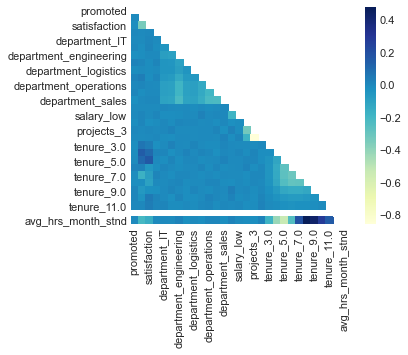

In [ ]:
plt.style.use('seaborn-white')
# Calculate correlation between each pair of variable
corr_matrix=df.corr()
 
# Can be great to plot only a half matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, square=True, cmap="YlGnBu")

In [ ]:
df.drop(['tenure_7.0'], axis=1, inplace=True)

In [ ]:
X = df.drop(['target'],axis=1) 
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [ ]:
X = add_constant(X_train.iloc[:,1:])
vif=pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
              index=X.columns)
pd.DataFrame(vif)[0].sort_values(ascending=False)

const                     126.443582
avg_hrs_month_stnd         22.840415
tenure_5.0                  8.796332
tenure_4.0                  6.285345
tenure_6.0                  4.014379
tenure_9.0                  3.545061
tenure_8.0                  2.871767
department_sales            2.831590
department_retail           2.584583
department_operations       2.575762
department_engineering      2.541620
tenure_10.0                 2.344915
tenure_3.0                  1.942355
department_marketing        1.894811
department_admin            1.507877
department_finance          1.491547
tenure_11.0                 1.473257
department_logistics        1.430868
department_IT               1.426855
review                      1.284637
satisfaction                1.267232
salary_high                 1.038667
salary_low                  1.036517
projects_2                  1.034862
projects_4                  1.034585
bonus                       1.002734
tenure_12.0                      NaN
N

In [ ]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

## Model Building

In [ ]:
df.target.value_counts()

0    6756
1    2784
Name: target, dtype: int64

In [ ]:
!pip install imbalanced-learn

     |████████████████████████████████| 199 kB 33.0 MB/s            
     |████████████████████████████████| 26.7 MB 107.5 MB/s            
     |████████████████████████████████| 306 kB 93.4 MB/s            
     |████████████████████████████████| 41.6 MB 90.9 MB/s            
     |████████████████████████████████| 16.8 MB 52.6 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.4.1 requires numpy~=1.19.2, but you have numpy 1.22.2 which is incompatible.
pythonwhat 2.23.1 requires dill~=0.2.7.1, but you have dill 0.3.3 which is incompatible.
pythonwhat 2.23.1 requires jinja2~=2.10, but you have jinja2 3.0.1 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Due to the imbalance of the dataset, SMOTE is applied to oversample minority class.

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=10)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

0    5426
1    5426
Name: target, dtype: int64

### Gradient Boosting Classifier

In [ ]:
k=0
ModelSummary = {}

In [ ]:
predictors = [x for x in df.columns if x not in ['target']]


Gradient Boosting Classifier Report
Accuracy: 0.8129
AUC Score: 0.896885


Text(0, 0.5, 'Feature Importance Score')

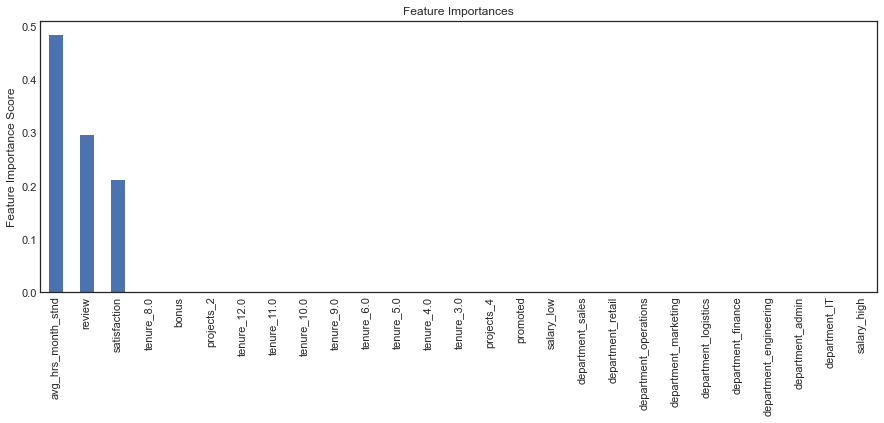

In [ ]:
model_gbc = GradientBoostingClassifier(n_estimators = 10, random_state=10)
model_gbc.fit(X_train,y_train)

y_pred_gbc = model_gbc.predict(X_test)
y_pred_gbc_prob = model_gbc.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nGradient Boosting Classifier Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_gbc))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_gbc_prob))

feat_imp = pd.Series(model_gbc.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Model Tuning

n_estimators

In [ ]:
param_test1 = {'n_estimators':range(50,301,50)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               min_samples_split=500,
                                                               min_samples_leaf=50,
                                                               max_depth=8,
                                                               max_features='sqrt',
                                                               subsample=0.8,
                                                               random_state=10), 
                                                            param_grid = param_test1, 
                                                            scoring='roc_auc',n_jobs=6,cv=5)
gsearch1.fit(X_train, y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

{'n_estimators': 300} 0.9457566289484273


max_depth & min_samples_split

In [ ]:
param_test2 = {'max_depth':range(10,16,2), 'min_samples_split':range(10,21,5)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               n_estimators=300, 
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=10), 
                                                            param_grid = param_test2, 
                                                            scoring='roc_auc',n_jobs=1,cv=5)
gsearch2.fit(X_train, y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'max_depth': 14, 'min_samples_split': 10} 0.958603719214041


min_samples_leaf

In [ ]:
param_test3 = {'min_samples_leaf':range(10,31,5)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               n_estimators=300,
                                                               max_depth=14,
                                                               min_samples_split=10,
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=10), 
                                                            param_grid = param_test3, 
                                                            scoring='roc_auc',n_jobs=1,cv=5)
gsearch3.fit(X_train, y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

{'min_samples_leaf': 10} 0.9547202596298291


max_features

In [ ]:
param_test4 = {'max_features':range(5,12,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               n_estimators=300,
                                                               max_depth=14,
                                                               min_samples_split=10,
                                                               min_samples_leaf=10,
                                                               max_features='sqrt', 
                                                               subsample=0.8, 
                                                               random_state=10), 
                                                            param_grid = param_test4, 
                                                            scoring='roc_auc',n_jobs=1,cv=5)
gsearch4.fit(X_train, y_train)
print(gsearch4.best_params_, gsearch4.best_score_)

{'max_features': 5} 0.9547202596298291


subsample

In [ ]:
param_test5 = {'subsample':[0.5,0.55,0.6,0.65]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.15, 
                                                               n_estimators=300,
                                                               max_depth=14,
                                                               min_samples_split=10,
                                                               min_samples_leaf=10,
                                                               max_features=5, 
                                                               subsample=0.8, 
                                                               random_state=10), 
                                                            param_grid = param_test5, 
                                                            scoring='roc_auc',n_jobs=1,cv=5)
gsearch5.fit(X_train, y_train)
print(gsearch5.best_params_, gsearch4.best_score_)

{'subsample': 0.65} 0.9547202596298291



Tuned Gradient Boosting Classifier Report
Accuracy: 0.8307
AUC Score: 0.908481


Text(0, 0.5, 'Feature Importance Score')

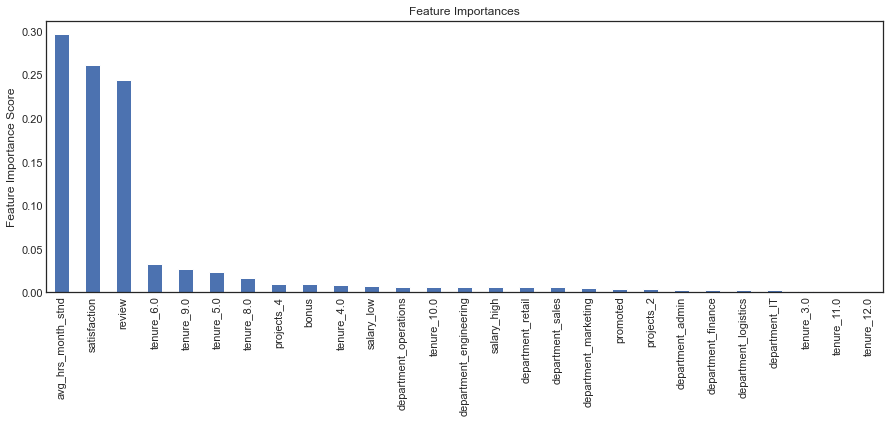

In [ ]:
model_gbc_tuned = GradientBoostingClassifier(learning_rate=0.15, 
                                            n_estimators=300,
                                            max_depth=14,
                                            min_samples_split=10,
                                            min_samples_leaf=10,
                                            max_features=5, 
                                            subsample=0.65, 
                                            random_state=42)
model_gbc_tuned.fit(X_train,y_train)

y_pred_gbc_tuned = model_gbc_tuned.predict(X_test)
y_pred_gbc_prob_tuned = model_gbc_tuned.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nTuned Gradient Boosting Classifier Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_gbc_tuned))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_gbc_prob_tuned))

feat_imp = pd.Series(model_gbc_tuned.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

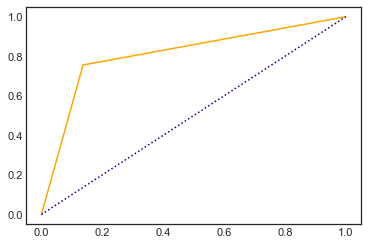

In [ ]:
#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_gbc_tuned)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

[[1148  141]
 [ 182  437]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88      1289
           1       0.76      0.71      0.73       619

    accuracy                           0.83      1908
   macro avg       0.81      0.80      0.80      1908
weighted avg       0.83      0.83      0.83      1908



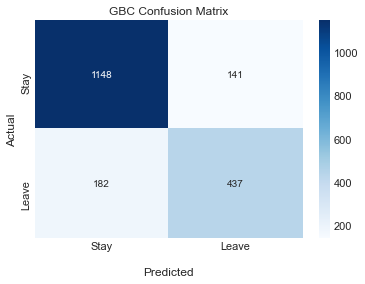

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}}


In [ ]:
print(confusion_matrix(y_pred_gbc_tuned,y_test))
print(classification_report(y_pred_gbc_tuned,y_test))

ax = sns.heatmap(confusion_matrix(y_pred_gbc_tuned,y_test), 
                 annot=True, fmt='g', cmap='Blues')

ax.set_title('GBC Confusion Matrix');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

ax.xaxis.set_ticklabels(['Stay','Leave'])
ax.yaxis.set_ticklabels(['Stay','Leave'])
plt.show()

#ProjectSummary
ModelName = 'GradientBoosting_classification'
Acc = accuracy_score(y_pred_gbc_tuned,y_test)
pres = precision_score(y_pred_gbc_tuned,y_test)
recal = recall_score(y_pred_gbc_tuned,y_test)
f1score = f1_score(y_pred_gbc_tuned,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)


### Logistic Regression

In [ ]:
logreg = LogisticRegression().fit(X_train, y_train)
logreg.fit(X_train,y_train)
y_pred_logreg=logreg.predict(X_test)

penalty = ['l1', 'l2']
C = [0.1,1]
hyperparameters = dict(C=C, penalty=penalty)
grid_logreg = GridSearchCV(logreg, hyperparameters, cv=3, verbose=0)

grid_logreg.fit(X_train, y_train)
y_pred_logreg = grid_logreg.predict(X_test)

In [ ]:
coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",logreg.coef_.transpose())

In [ ]:
coef_table.rename({0:'Feature'},axis=1,inplace=True)
coef_table = coef_table.sort_values(by=['Coefs'], ascending=False)
coef_table.head(1)

,Feature,Coefs
1,review,13.571322


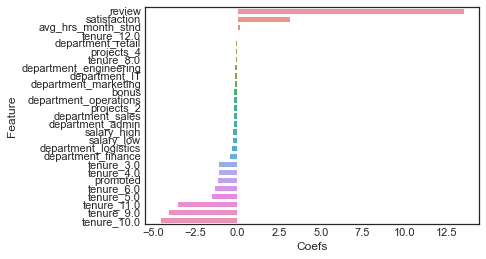

In [ ]:
sns.barplot(y="Feature", x="Coefs", data=coef_table);

[[940 145]
 [390 433]]
              precision    recall  f1-score   support

           0       0.71      0.87      0.78      1085
           1       0.75      0.53      0.62       823

    accuracy                           0.72      1908
   macro avg       0.73      0.70      0.70      1908
weighted avg       0.73      0.72      0.71      1908



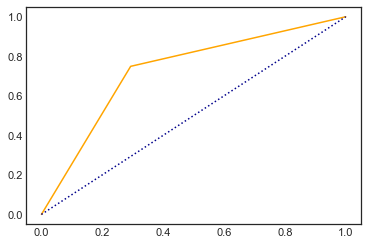

In [ ]:
print(confusion_matrix(y_pred_logreg,y_test))
print(classification_report(y_pred_logreg,y_test))

#ProjectSummary
ModelName = 'Logistic_Regression_classification'
Acc = accuracy_score(y_pred_logreg,y_test)
pres = precision_score(y_pred_logreg,y_test)
recal = recall_score(y_pred_logreg,y_test)
f1score = f1_score(y_pred_logreg,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1

#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_logreg)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

### KNN Classification

Find optimal K

In [ ]:
accuracy_CV=[]
for i in range(2,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    scores_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    accuracy_CV.append(scores_knn.mean()) 

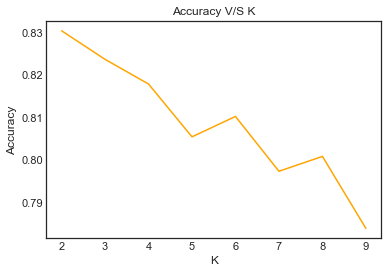

In [ ]:
plt.plot(list(range(2,10)),accuracy_CV,color="orange",label="Accuracy")
plt.title("Accuracy V/S K")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.show()

KNeighborsClassifier Model Accuracy :  0.7783018867924528
[[1181  274]
 [ 149  304]]
              precision    recall  f1-score   support

           0       0.89      0.81      0.85      1455
           1       0.53      0.67      0.59       453

    accuracy                           0.78      1908
   macro avg       0.71      0.74      0.72      1908
weighted avg       0.80      0.78      0.79      1908

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}, 1: {'ModelName': 'Logistic_Regression_classification', 'ModeAccuracy': 0.7196016771488469, 'Precision': 0.7491349480968859, 'Recall': 0.5261239368165249, 'f1score': 0.6181299072091363}, 2: {'ModelName': 'KNeighbors_classification', 'ModeAccuracy': 0.7783018867924528, 'Precision': 0.5259515570934256, 'Recall': 0.6710816777041942, 'f1score': 0.5897187196896216}}


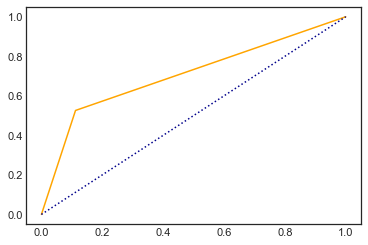

In [ ]:
knn_tuned = KNeighborsClassifier(n_neighbors=2)
knn_tuned.fit(X_train,y_train)
y_pred_knn = knn_tuned.predict(X_test)

print('KNeighborsClassifier Model Accuracy : ', accuracy_score(y_pred_knn,y_test))
print(confusion_matrix(y_pred_knn,y_test))
print(classification_report(y_pred_knn,y_test))

#ProjectSummary
ModelName = 'KNeighbors_classification'
Acc = accuracy_score(y_pred_knn,y_test)
pres = precision_score(y_pred_knn,y_test)
recal = recall_score(y_pred_knn,y_test)
f1score = f1_score(y_pred_knn,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)

#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_knn)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

## Random Forest

In [ ]:
rf=RandomForestClassifier()
rf.fit(X_train,y_train)
y_pred_rf=rf.predict(X_test)

In [ ]:
params ={
    'criterion':['gini','entropy'],
    'n_estimators':[int(x) for x in np.linspace(start=100 ,stop=1000,num=10)],
    'max_depth':[int(x) for x in np.linspace(10,1000,10)],
    'max_features':['auto','sqrt','log2'],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4,6,8]
}

In [ ]:
rf=RandomizedSearchCV(estimator=rf,param_distributions=params,
                      n_iter=5,scoring='accuracy',cv=5,verbose=2,
                      n_jobs=-1,random_state=10)

rf.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=10, scoring='accuracy', verbose=2)

In [ ]:
rf.best_params_

{'n_estimators': 1000,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 230,
 'criterion': 'gini'}

In [ ]:
best_random =rf.best_estimator_
best_random

RandomForestClassifier(max_depth=230, max_features='log2', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=1000)

In [ ]:
rf_tuned = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=230, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf_tuned.fit(X_train,y_train)
y_pred_rf = rf_tuned.predict(X_test)
print('RandomForestClassifier Model Accuracy : ', accuracy_score(y_pred_rf,y_test))
confusion_matrix(y_pred_rf,y_test)

RandomForestClassifier Model Accuracy :  0.8359538784067087


array([[1140,  123],
       [ 190,  455]])

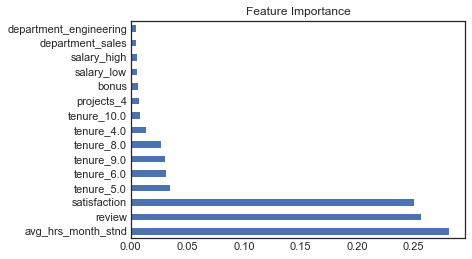

In [ ]:
feat_importances = pd.Series(rf_tuned.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}, 1: {'ModelName': 'Logistic_Regression_classification', 'ModeAccuracy': 0.7196016771488469, 'Precision': 0.7491349480968859, 'Recall': 0.5261239368165249, 'f1score': 0.6181299072091363}, 2: {'ModelName': 'KNeighbors_classification', 'ModeAccuracy': 0.7783018867924528, 'Precision': 0.5259515570934256, 'Recall': 0.6710816777041942, 'f1score': 0.5897187196896216}, 3: {'ModelName': 'RandomForest_classification', 'ModeAccuracy': 0.8359538784067087, 'Precision': 0.78719723183391, 'Recall': 0.7054263565891473, 'f1score': 0.7440719542109566}}


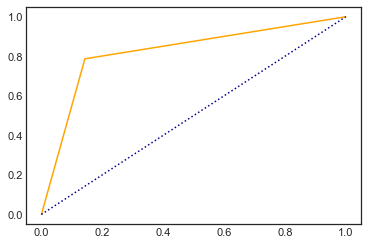

In [ ]:
#ProjectSummary
ModelName = 'RandomForest_classification'
Acc = accuracy_score(y_pred_rf,y_test)
pres = precision_score(y_pred_rf,y_test)
recal = recall_score(y_pred_rf,y_test)
f1score = f1_score(y_pred_rf,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)

#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_rf)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

### Adaboost

In [ ]:
ada = AdaBoostClassifier(random_state=42)
ada_grid = {'n_estimators': range(50,150,10),
            'algorithm': ['SAMME','SAMME.R'],
            'learning_rate': [0.001,0.1,0.2,0.5]
              }

In [ ]:
ada=GridSearchCV(estimator=ada
                ,param_grid=ada_grid
                ,n_jobs=-1
                ,scoring='accuracy'
                ,cv=5
                )

In [ ]:
ada.fit(X_train,y_train)
ada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.5, 'n_estimators': 90}

In [ ]:
ada_tuned = AdaBoostClassifier(algorithm='SAMME.R',
                               learning_rate=0.5,
                               n_estimators=90)
ada_tuned.fit(X_train,y_train)
y_pred_ada = ada_tuned.predict(X_test)
print('AdaBoostClassifier Model Accuracy : ', accuracy_score(y_pred_ada,y_test)*100,'%')
confusion_matrix(y_pred_ada,y_test)

AdaBoostClassifier Model Accuracy :  78.72117400419287 %


array([[1047,  123],
       [ 283,  455]])

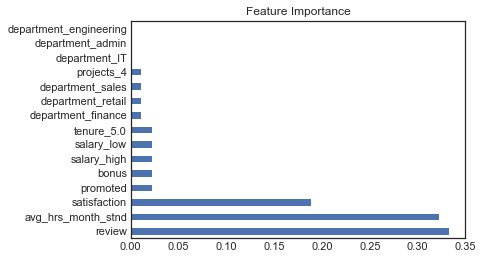

In [ ]:
feat_importances = pd.Series(ada_tuned.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title("Feature Importance")
plt.show()

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}, 1: {'ModelName': 'Logistic_Regression_classification', 'ModeAccuracy': 0.7196016771488469, 'Precision': 0.7491349480968859, 'Recall': 0.5261239368165249, 'f1score': 0.6181299072091363}, 2: {'ModelName': 'KNeighbors_classification', 'ModeAccuracy': 0.7783018867924528, 'Precision': 0.5259515570934256, 'Recall': 0.6710816777041942, 'f1score': 0.5897187196896216}, 3: {'ModelName': 'RandomForest_classification', 'ModeAccuracy': 0.8359538784067087, 'Precision': 0.78719723183391, 'Recall': 0.7054263565891473, 'f1score': 0.7440719542109566}, 4: {'ModelName': 'AdaBoosting_classification', 'ModeAccuracy': 0.7872117400419287, 'Precision': 0.78719723183391, 'Recall': 0.6165311653116531, 'f1score': 0.6914893617021276}}


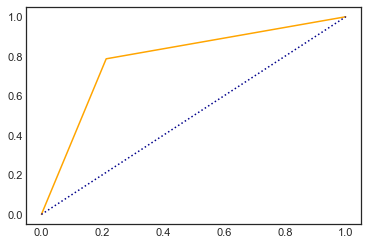

In [ ]:
#ProjectSummary
ModelName = 'AdaBoosting_classification'
Acc = accuracy_score(y_pred_ada,y_test)
pres = precision_score(y_pred_ada,y_test)
recal = recall_score(y_pred_ada,y_test)
f1score = f1_score(y_pred_ada,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)

#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_ada)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

### XGBoost

In [ ]:
xgb = XGBClassifier(learning_rate =0.1,
                    n_estimators=1000,
                    max_depth=5,
                    min_child_weight=1,
                    gamma=0,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread=4,
                    scale_pos_weight=1
                    )
xgb.fit(X_train, y_train)

[10:17:47] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)


XGB Model Report
Accuracy: 0.8307
AUC Score: 0.918963


Text(0, 0.5, 'Feature Importance Score')

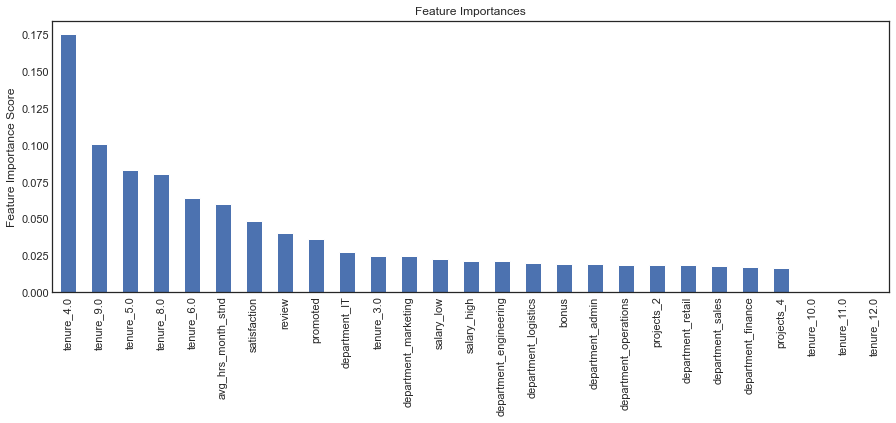

In [ ]:
y_pred_xgb = xgb.predict(X_test)
y_pred_prob_xgb = xgb.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nXGB Model Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_xgb))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_prob_xgb))

feat_imp = pd.Series(xgb.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

#### Model Tuning

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140,
                                                  max_depth=5,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=27,
                                                 eval_metric='rmse'), 
                        param_grid = param_test1, scoring='roc_auc',
                        n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

{'max_depth': 9, 'min_child_weight': 1} 0.9489568987091449
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time=   0.0s
[CV] END criterion=entropy, max_depth=670, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END criterion=entropy, max_depth=670, max_features=auto, min_samples_leaf=6, min_samples_split=2, n_estimators=400; total time=   0.0s
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_estimators=500; total time=   0.0s
[CV] END criterion=gini, max_depth=230, max_features=log2, min_samples_leaf=8, min_samples_split=10, n_est

In [ ]:
param_test2 = {
 'max_depth':range(9,14,1),
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, 
                                                  n_estimators=140,
                                                  max_depth=9,
                                                  min_child_weight=1, 
                                                  gamma=0, 
                                                  subsample=0.8, 
                                                  colsample_bytree=0.8,
                                                  objective= 'binary:logistic', 
                                                  nthread=4, 
                                                  scale_pos_weight=1, 
                                                  seed=27,
                                                 eval_metric='rmse'), 
                        param_grid = param_test2, scoring='roc_auc',
                        n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'gamma': 0.1, 'max_depth': 11} 0.9505312198479061


In [ ]:
xgb_tuned = XGBClassifier(learning_rate =0.1,
                             n_estimators=1000,
                             max_depth=11,
                             min_child_weight=1,
                             gamma=0.1,
                             subsample=0.8,
                             colsample_bytree=0.8,
                             objective= 'binary:logistic',
                             nthread=4,
                             scale_pos_weight=1,
                             seed=27)


XGB Tuned Model Report
Accuracy: 0.8312
AUC Score: 0.911720


Text(0, 0.5, 'Feature Importance Score')

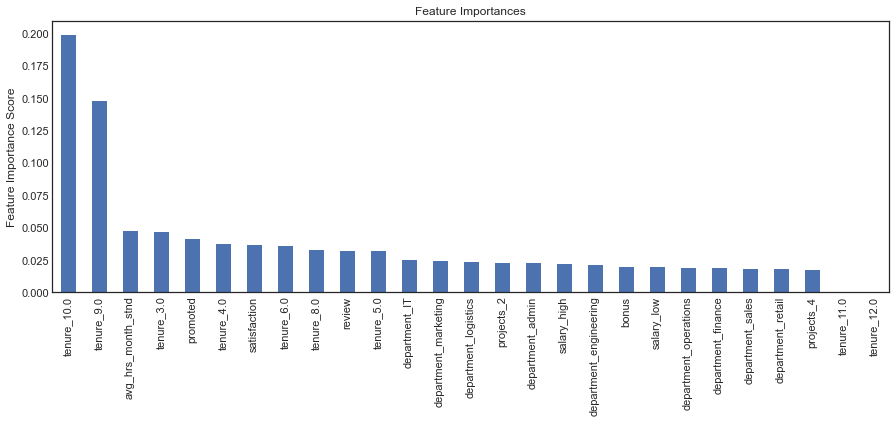

In [ ]:
xgb_tuned.fit(X_train, y_train,eval_metric='rmse')
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
y_pred_prob_xgb_tuned = xgb_tuned.predict_proba(X_test)[:,1]
       
#Print model report:
print("\nXGB Tuned Model Report")
print('Accuracy: %.4g' % metrics.accuracy_score(y_test.values,y_pred_xgb_tuned))
print('AUC Score: %f' % metrics.roc_auc_score(y_test,y_pred_prob_xgb_tuned))

feat_imp = pd.Series(xgb_tuned.feature_importances_,predictors).sort_values(ascending=False)
fig = plt.figure(figsize=(15,5))
feat_imp[:80].plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

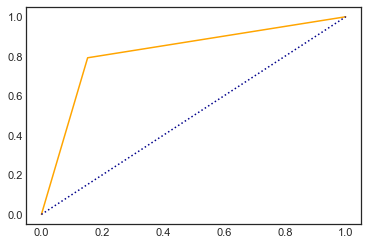

In [ ]:
#ROC curve

fpr , tpr, threshold = roc_curve(y_test,y_pred_xgb_tuned)
plt.plot(fpr,tpr,color='orange',label='ROC')
plt.plot([0,1],[0,1],color='darkblue',linestyle='dotted')

In [ ]:
print(confusion_matrix(y_pred_xgb_tuned,y_test))
print(classification_report(y_pred_xgb_tuned,y_test))

#ProjectSummary
ModelName = 'XGBoosting_classification'
Acc = accuracy_score(y_pred_xgb_tuned,y_test)
pres = precision_score(y_pred_xgb_tuned,y_test)
recal = recall_score(y_pred_xgb_tuned,y_test)
f1score = f1_score(y_pred_xgb_tuned,y_test)
ModelSummary[k] = {}
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModelName'] = ModelName
ModelSummary[k]['ModeAccuracy'] = Acc
ModelSummary[k]['Precision'] = pres
ModelSummary[k]['Recall'] = recal
ModelSummary[k]['f1score'] = f1score
k=k+1
print(ModelSummary)

[[1128  120]
 [ 202  458]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88      1248
           1       0.79      0.69      0.74       660

    accuracy                           0.83      1908
   macro avg       0.82      0.80      0.81      1908
weighted avg       0.83      0.83      0.83      1908

{0: {'ModelName': 'GradientBoosting_classification', 'ModeAccuracy': 0.8307127882599581, 'Precision': 0.7560553633217993, 'Recall': 0.7059773828756059, 'f1score': 0.7301587301587302}, 1: {'ModelName': 'Logistic_Regression_classification', 'ModeAccuracy': 0.7196016771488469, 'Precision': 0.7491349480968859, 'Recall': 0.5261239368165249, 'f1score': 0.6181299072091363}, 2: {'ModelName': 'KNeighbors_classification', 'ModeAccuracy': 0.7783018867924528, 'Precision': 0.5259515570934256, 'Recall': 0.6710816777041942, 'f1score': 0.5897187196896216}, 3: {'ModelName': 'RandomForest_classification', 'ModeAccuracy': 0.8359538784067087, 'Precision': 0.

In [ ]:
ModelName,ModeAccuracy,Precision,Recall,f1score = [],[],[],[],[]
import json
sorted_json_data = json.dumps(ModelSummary, sort_keys=True)
finalJson = json.loads(sorted_json_data)
finalJson
for i in range(len(finalJson)):
    List = finalJson[str(i)]
    ModelName.append(List['ModelName'])
    ModeAccuracy.append(List['ModeAccuracy'])
    Precision.append(List['Precision'])
    Recall.append(List['Recall'])
    f1score.append(List['f1score'])
df = pd.DataFrame()
df['ModelName'] = ModelName
df['ModeAccuracy'] = ModeAccuracy
df['Precision'] = Precision
df['Recall'] = Recall
df['f1score'] = f1score

df

,ModelName,ModeAccuracy,Precision,Recall,f1score
0,GradientBoosting_classification,0.830713,0.756055,0.705977,0.730159
1,Logistic_Regression_classification,0.719602,0.749135,0.526124,0.618130
2,KNeighbors_classification,0.778302,0.525952,0.671082,0.589719
3,RandomForest_classification,0.835954,0.787197,0.705426,0.744072
4,AdaBoosting_classification,0.787212,0.787197,0.616531,0.691489
5,XGBoosting_classification,0.831237,0.792388,0.693939,0.739903


In [ ]:
# Model with highest accuracy
df.sort_values('ModeAccuracy',ascending=False).head(1)

,ModelName,ModeAccuracy,Precision,Recall,f1score
3,RandomForest_classification,0.835954,0.787197,0.705426,0.744072


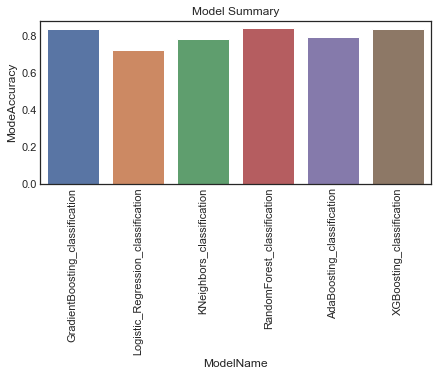

In [ ]:
plt.figure(figsize=(7,3))
sns.barplot(df['ModelName'],df['ModeAccuracy'])
plt.title('Model Summary')
plt.xticks(rotation=90)
plt.show()

For models with higher accuracies like Gradient Boosting Classifier, Random Forest and XGBoost Classifier, there are common features which are regarded as significant: average hours per month, review, satisfaction. 


#### Average Hours Per Month

In [ ]:
# Sample same number of data points from both classes
df_bal = df2.groupby('left').apply(lambda s: s.sample(800)).reset_index(drop=True)

In [ ]:
df_bal.left.value_counts()

no     800
yes    800
Name: left, dtype: int64

In [ ]:
left_avg = pd.DataFrame(df_bal[df_bal["left"]=="yes"]['avg_hrs_month']).reset_index()
stay_avg = pd.DataFrame(df_bal[df_bal["left"]=="no"]['avg_hrs_month']).reset_index()

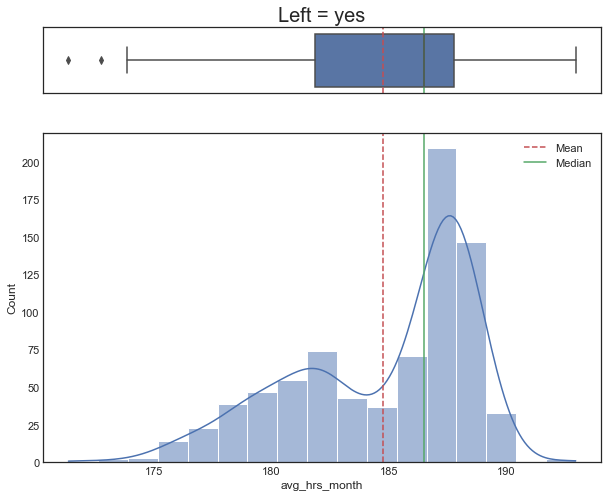

In [ ]:
rcParams['figure.figsize'] = 10,8
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=left_avg['avg_hrs_month'].mean()
median=left_avg['avg_hrs_month'].median()

sns.boxplot(data=left_avg, x="avg_hrs_month", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.histplot(data=left_avg, x="avg_hrs_month", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")

ax_hist.legend()

ax_box.set(xlabel='')
ax_box.set_title('Left = yes', fontsize=20)
plt.show()

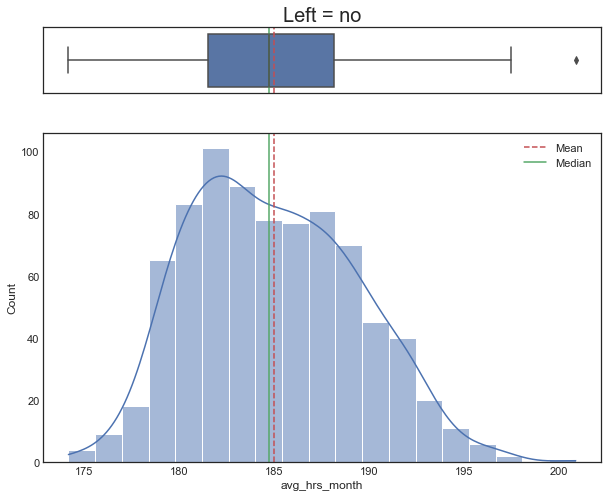

In [ ]:
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.2, 1)})
mean=stay_avg['avg_hrs_month'].mean()
median=stay_avg['avg_hrs_month'].median()

sns.boxplot(data=stay_avg, x="avg_hrs_month", ax=ax_box)
ax_box.axvline(mean, color='r', linestyle='--')
ax_box.axvline(median, color='g', linestyle='-')

sns.histplot(data=stay_avg, x="avg_hrs_month", ax=ax_hist, kde=True)
ax_hist.axvline(mean, color='r', linestyle='--', label="Mean")
ax_hist.axvline(median, color='g', linestyle='-', label="Median")

ax_hist.legend()

ax_box.set(xlabel='')
ax_box.set_title('Left = no', fontsize=20)
plt.show()

By examining the charts above, the average working hours per month for two groups are similar -- 185 hours (approximately 9.25h/workday). Both groups have two peaks around 183 hrs and 187 hrs. However, the median for churned group is higher and has a left skewed distribution which means more people tend to work longer.

#### Review

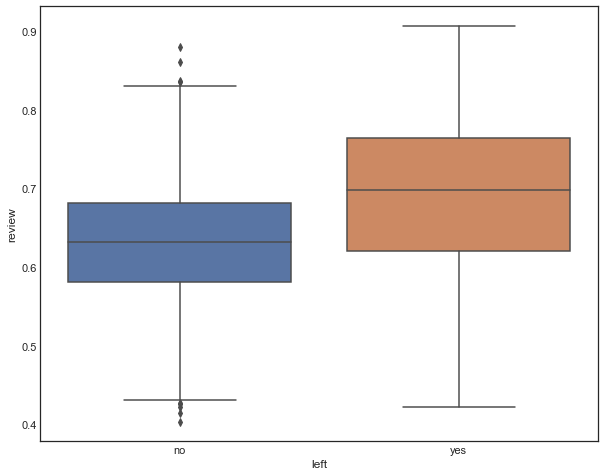

In [ ]:
sns.boxplot(x="left", y="review",
            data=df_bal);

Based on the box plot, churned employees have higher average review ratings and the variance is also larger. Employees who didn't leave tend to have lower review ratings.

#### Satisfaction

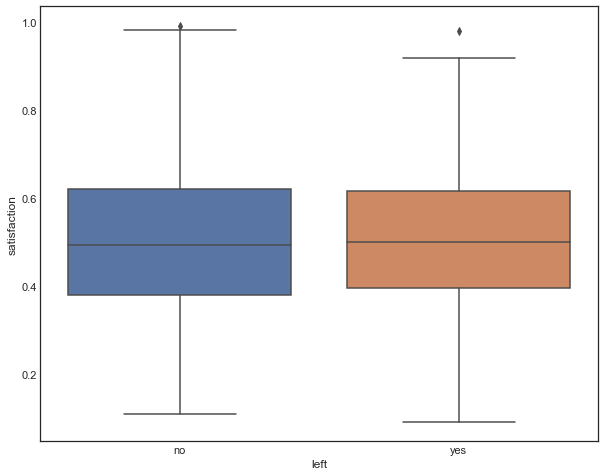

In [ ]:
sns.boxplot(x="left", y="satisfaction",
            data=df_bal);

Average satisfaction scores do not vary much from one group to the other. The ranges are similar too.

There are some other features which are considered important in other models including tenure and promoted. 

# Question 3

What recommendations would you make regarding ways to reduce employee turnover?

## Split projects and share the burden

Based on previous analysis, IT department is one of the departments with the highest employee churn rate and the average working hours per month is identified as a strong predictor for employee churn. From the boxplot below, it is obvious that people working at IT department have relatively high average working hours per month. 

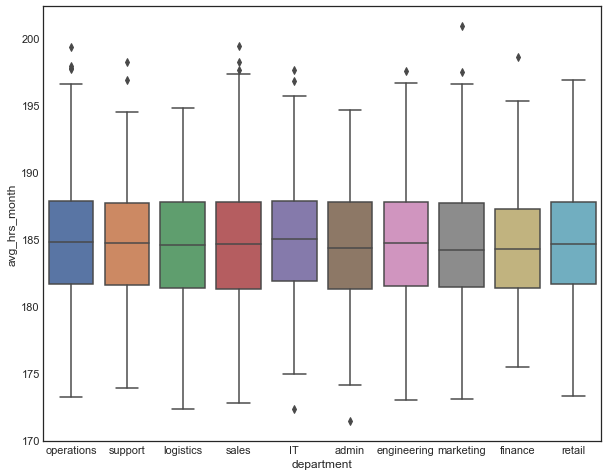

In [ ]:
rcParams['figure.figsize'] = 10,8
sns.boxplot(x="department", y="avg_hrs_month",
            data=df2);

One possible reason might be that IT people who lack the skills need to work longer hours to complete the target or project. For example, junior employees may take longer hours to code and deliver projects. However, from the plot of average work hours in IT department across all tenure groups, senior employees tend to have higher working hours. This leads to another possible reason that the senior employees have more projects to do.

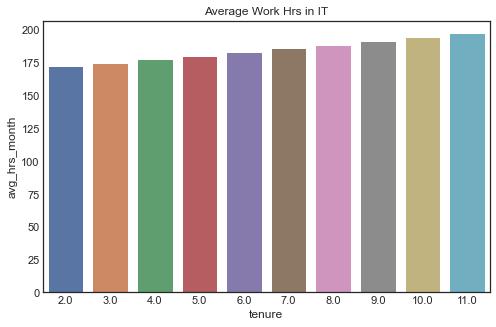

In [ ]:
rcParams['figure.figsize'] = 8,5
it_tenure_hrs = df2[df2['department']=='IT'].groupby('tenure')['avg_hrs_month'].mean().reset_index()

sns.barplot(x="tenure", y="avg_hrs_month",
            data=it_tenure_hrs).set_title('Average Work Hrs in IT');

Therefore, the next step is to see if there's a huge difference in the number of projects conducted between junior and senior people. 

From the graph below, apparently employees with 3 years of tenure tend to have the most projects to do. Also from the satisfaction plot, this group of people has the lowest satisfaction. Therefore, it is recommended to break the projects down and share some with employees with 2 years of experience to share the burden. This may help employees with too much work to maintain a more balanced work-life. 

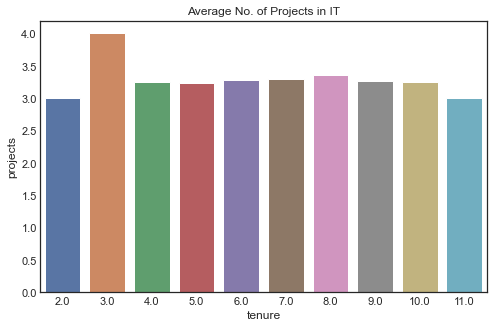

In [ ]:
it_tenure_prj = df2[df2['department']=='IT'].groupby('tenure')['projects'].mean().reset_index()

sns.barplot(x="tenure", y="projects",
            data=it_tenure_prj).set_title('Average No. of Projects in IT');

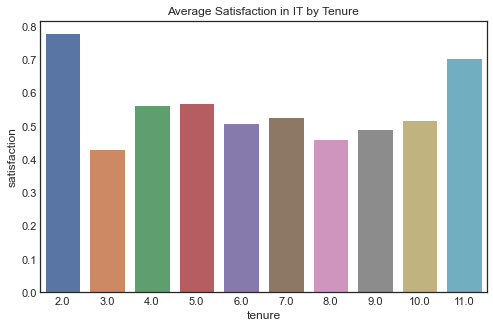

In [ ]:
it_tenure_sat = df2[df2['department']=='IT'].groupby('tenure')['satisfaction'].mean().reset_index()
sns.barplot(x="tenure", y="satisfaction",
            data=it_tenure_sat).set_title('Average Satisfaction in IT by Tenure');

## Establish fair and transparent promotion paths to get more mid-senior level employees promoted

In the group without promotion (promoted = 0), more people left.

From the boxplot below, there are employees with very high reviews weren't promoted in last 2 years. In addition, the average ratings for people who got promoted and those who didn't are very close. This implies that the promotion is not decided by reviews only, or the review itself is not a strong indicator for promotion. 

Articulating what employees need to achieve in order to get promoted might ensure each employee has a clear vision of what they lack and need to focus. 

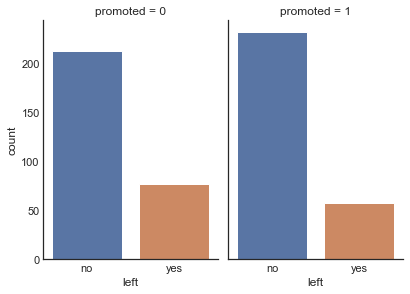

In [ ]:
p_cat = df2.groupby('promoted')
p_cat = pd.DataFrame(p_cat.apply(lambda x: x.sample(p_cat.size().min()).reset_index(drop=True)))
g = sns.catplot(x="left", col="promoted",
                data=p_cat, kind="count", col_wrap=2,
               height=4, aspect=.7);

In [ ]:
p_cat.promoted.value_counts()

0    289
1    289
Name: promoted, dtype: int64

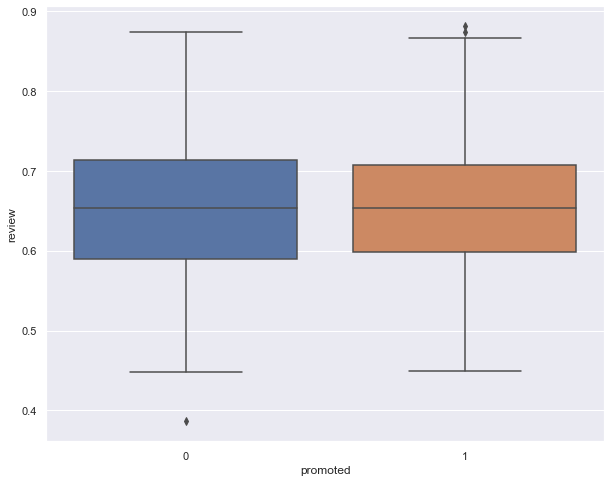

In [ ]:
rcParams['figure.figsize'] = 10,8
sns.boxplot(x="promoted", y="review",
            data=p_cat);

Another problem with promotion is that in the past 24 months, employees with long tenures were seldom promoted.

There might be a bias in below graph because people who got promoted in last 2 years now fall into a different tenure group. To capture the true satisfaction, an adjusted column is created so that any employees got promoted, the tenure is discounted.

In [ ]:
prom_cnt = df2.groupby(['tenure'])['promoted'].value_counts().reset_index(name = 'Count')
prom_cnt_y = prom_cnt[prom_cnt['promoted']==1]

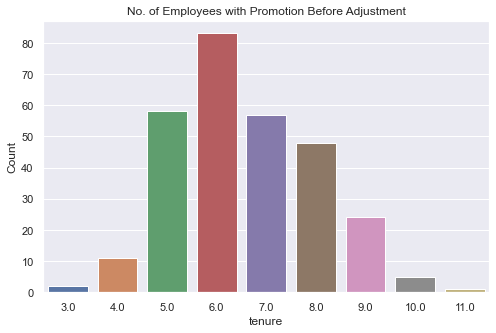

In [ ]:
rcParams['figure.figsize'] = 8,5
sns.barplot(x="tenure", 
            y="Count", 
            data=prom_cnt_y).set_title('No. of Employees with Promotion Before Adjustment');

In [ ]:
df2['tenure_adj'] = np.where(df2['promoted']==1, df2['tenure']-2, df2['tenure'])

In [ ]:
df2.promoted.value_counts()

0    9251
1     289
Name: promoted, dtype: int64

In [ ]:
df_bal_p = df2.groupby('promoted').apply(lambda s: s.sample(289)).reset_index(drop=True)
df_bal_p.promoted.value_counts()

0    289
1    289
Name: promoted, dtype: int64

In [ ]:
prom_cnt = df_bal_p.groupby(['tenure_adj'])['promoted'].value_counts().reset_index(name = 'Count')
prom_cnt_y = prom_cnt[prom_cnt['promoted']==1]

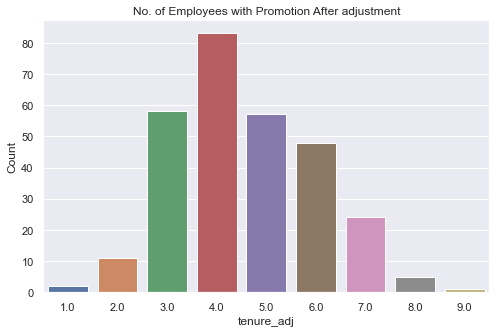

In [ ]:
sns.barplot(x="tenure_adj", 
            y="Count", 
            data=prom_cnt_y).set_title('No. of Employees with Promotion After adjustment');

No employees with 10 years or more tenures are shown above. This implies that senior level people may face hurdles in progressing their career.

Looking at the average satisfaction for employees with 8 to 10 years of tenure, they have lower satisfaction. 

In [ ]:
ten_pro_sat_adj = df_bal_p.groupby(['tenure_adj',
                              'left',
                              'promoted'])['satisfaction'].mean().reset_index(name = 'Avg. Satisfaction')
ten_pro_sat_prom_adj = ten_pro_sat_adj[ten_pro_sat_adj['promoted']==1]
ten_pro_sat_nonprom_adj = ten_pro_sat_adj[ten_pro_sat_adj['promoted']==0]

Text(0.5, 1.0, 'Not promoted')

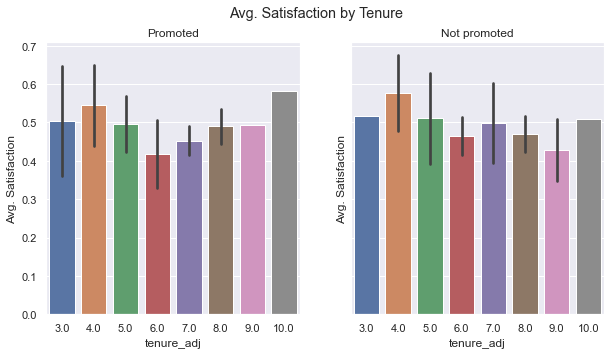

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle('Avg. Satisfaction by Tenure')

sns.barplot(ax=axes[0],
            x="tenure_adj", 
            y="Avg. Satisfaction", 
            data=ten_pro_sat_prom_adj).set_title('Promoted')
sns.barplot(ax=axes[1],
            x="tenure_adj", 
            y="Avg. Satisfaction", 
            data=ten_pro_sat_nonprom_adj).set_title('Not promoted')


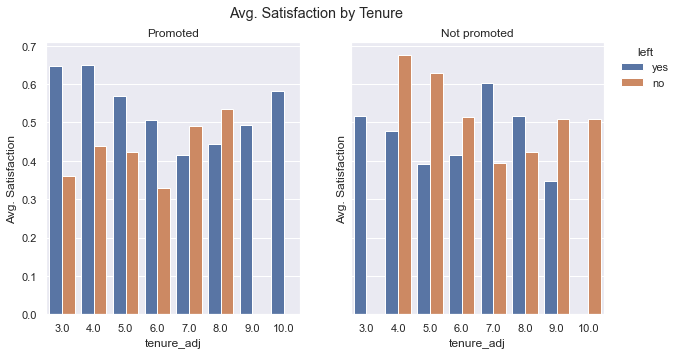

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle('Avg. Satisfaction by Tenure')

sns.barplot(ax=axes[0],
            x="tenure_adj", 
            y="Avg. Satisfaction", 
            hue="left", 
            data=ten_pro_sat_prom_adj).set_title('Promoted')
sns.barplot(ax=axes[1],
            x="tenure_adj", 
            y="Avg. Satisfaction", 
            hue="left", 
            data=ten_pro_sat_nonprom_adj).set_title('Not promoted')

axes[0].legend([],[], frameon=False)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, title='left',borderaxespad=0.);

## Implement comprehensive review metrics

This suggestion is linked to the previous one. For employees with high review ratings but didn't get promoted, the satisfaction of working in the company may decrease. This may explain why employees with high review ratings can have low satisfaction rate. 

Becuase not everyone who has a high rating can be promoted or rewarded, an accurate and comprehensive review to capture employees' performance and reflect the real situation and help employees identify areas for improvement. A spurious high review score will set the expectation too high, as employees may anticipate they will get promoted. A comprehensive metrics can motivate them to work and cultivate a positive working culture. Consequently, employees can receive a fair rating without to be disappointed.

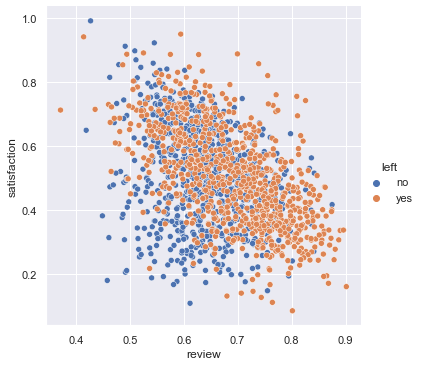

In [ ]:
sns.relplot(x="review", y="satisfaction", 
            hue="left", data=df_bal);

To further clarify, after plotting the linear relationship between average work hours and reviews, both features are not good at separating promoted and unpromoted employees. People with low average work hours and low review ratings can also be promoted, which sounds counter intuitive and might be one of the reasons for people to leave.

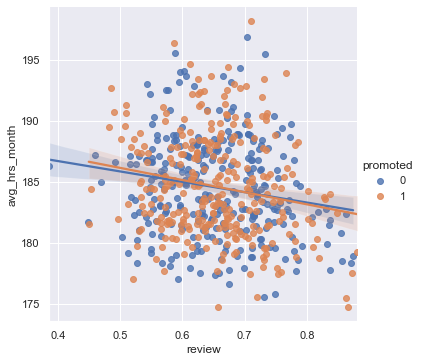

In [ ]:
g = sns.lmplot(
    data=p_cat,
    x="review", y="avg_hrs_month", hue="promoted",
    height=5
);